# Notes

In [136]:
# 1. Check iter_cb() function of lmfit - possibility to run anything at each iteration of fitting. 
# Good to input progressbar or some fancy stuff

# 2. ! Now I am feeding PC activity from the average of whole population. That means I am not capturing trends from
# depressors and sensitisors. Maybe, we need to add sub-populations activities to the model?

# 3. Look for different activation functions (examples from neuron networks). Check papers.

# Imports

In [137]:
%%time
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from lmfit import minimize, Parameter, Parameters, report_fit
from IPython import display
import datetime
#from progressbar import progressbar
#from numba import jit


CPU times: total: 0 ns
Wall time: 1 ms


# Model diagram

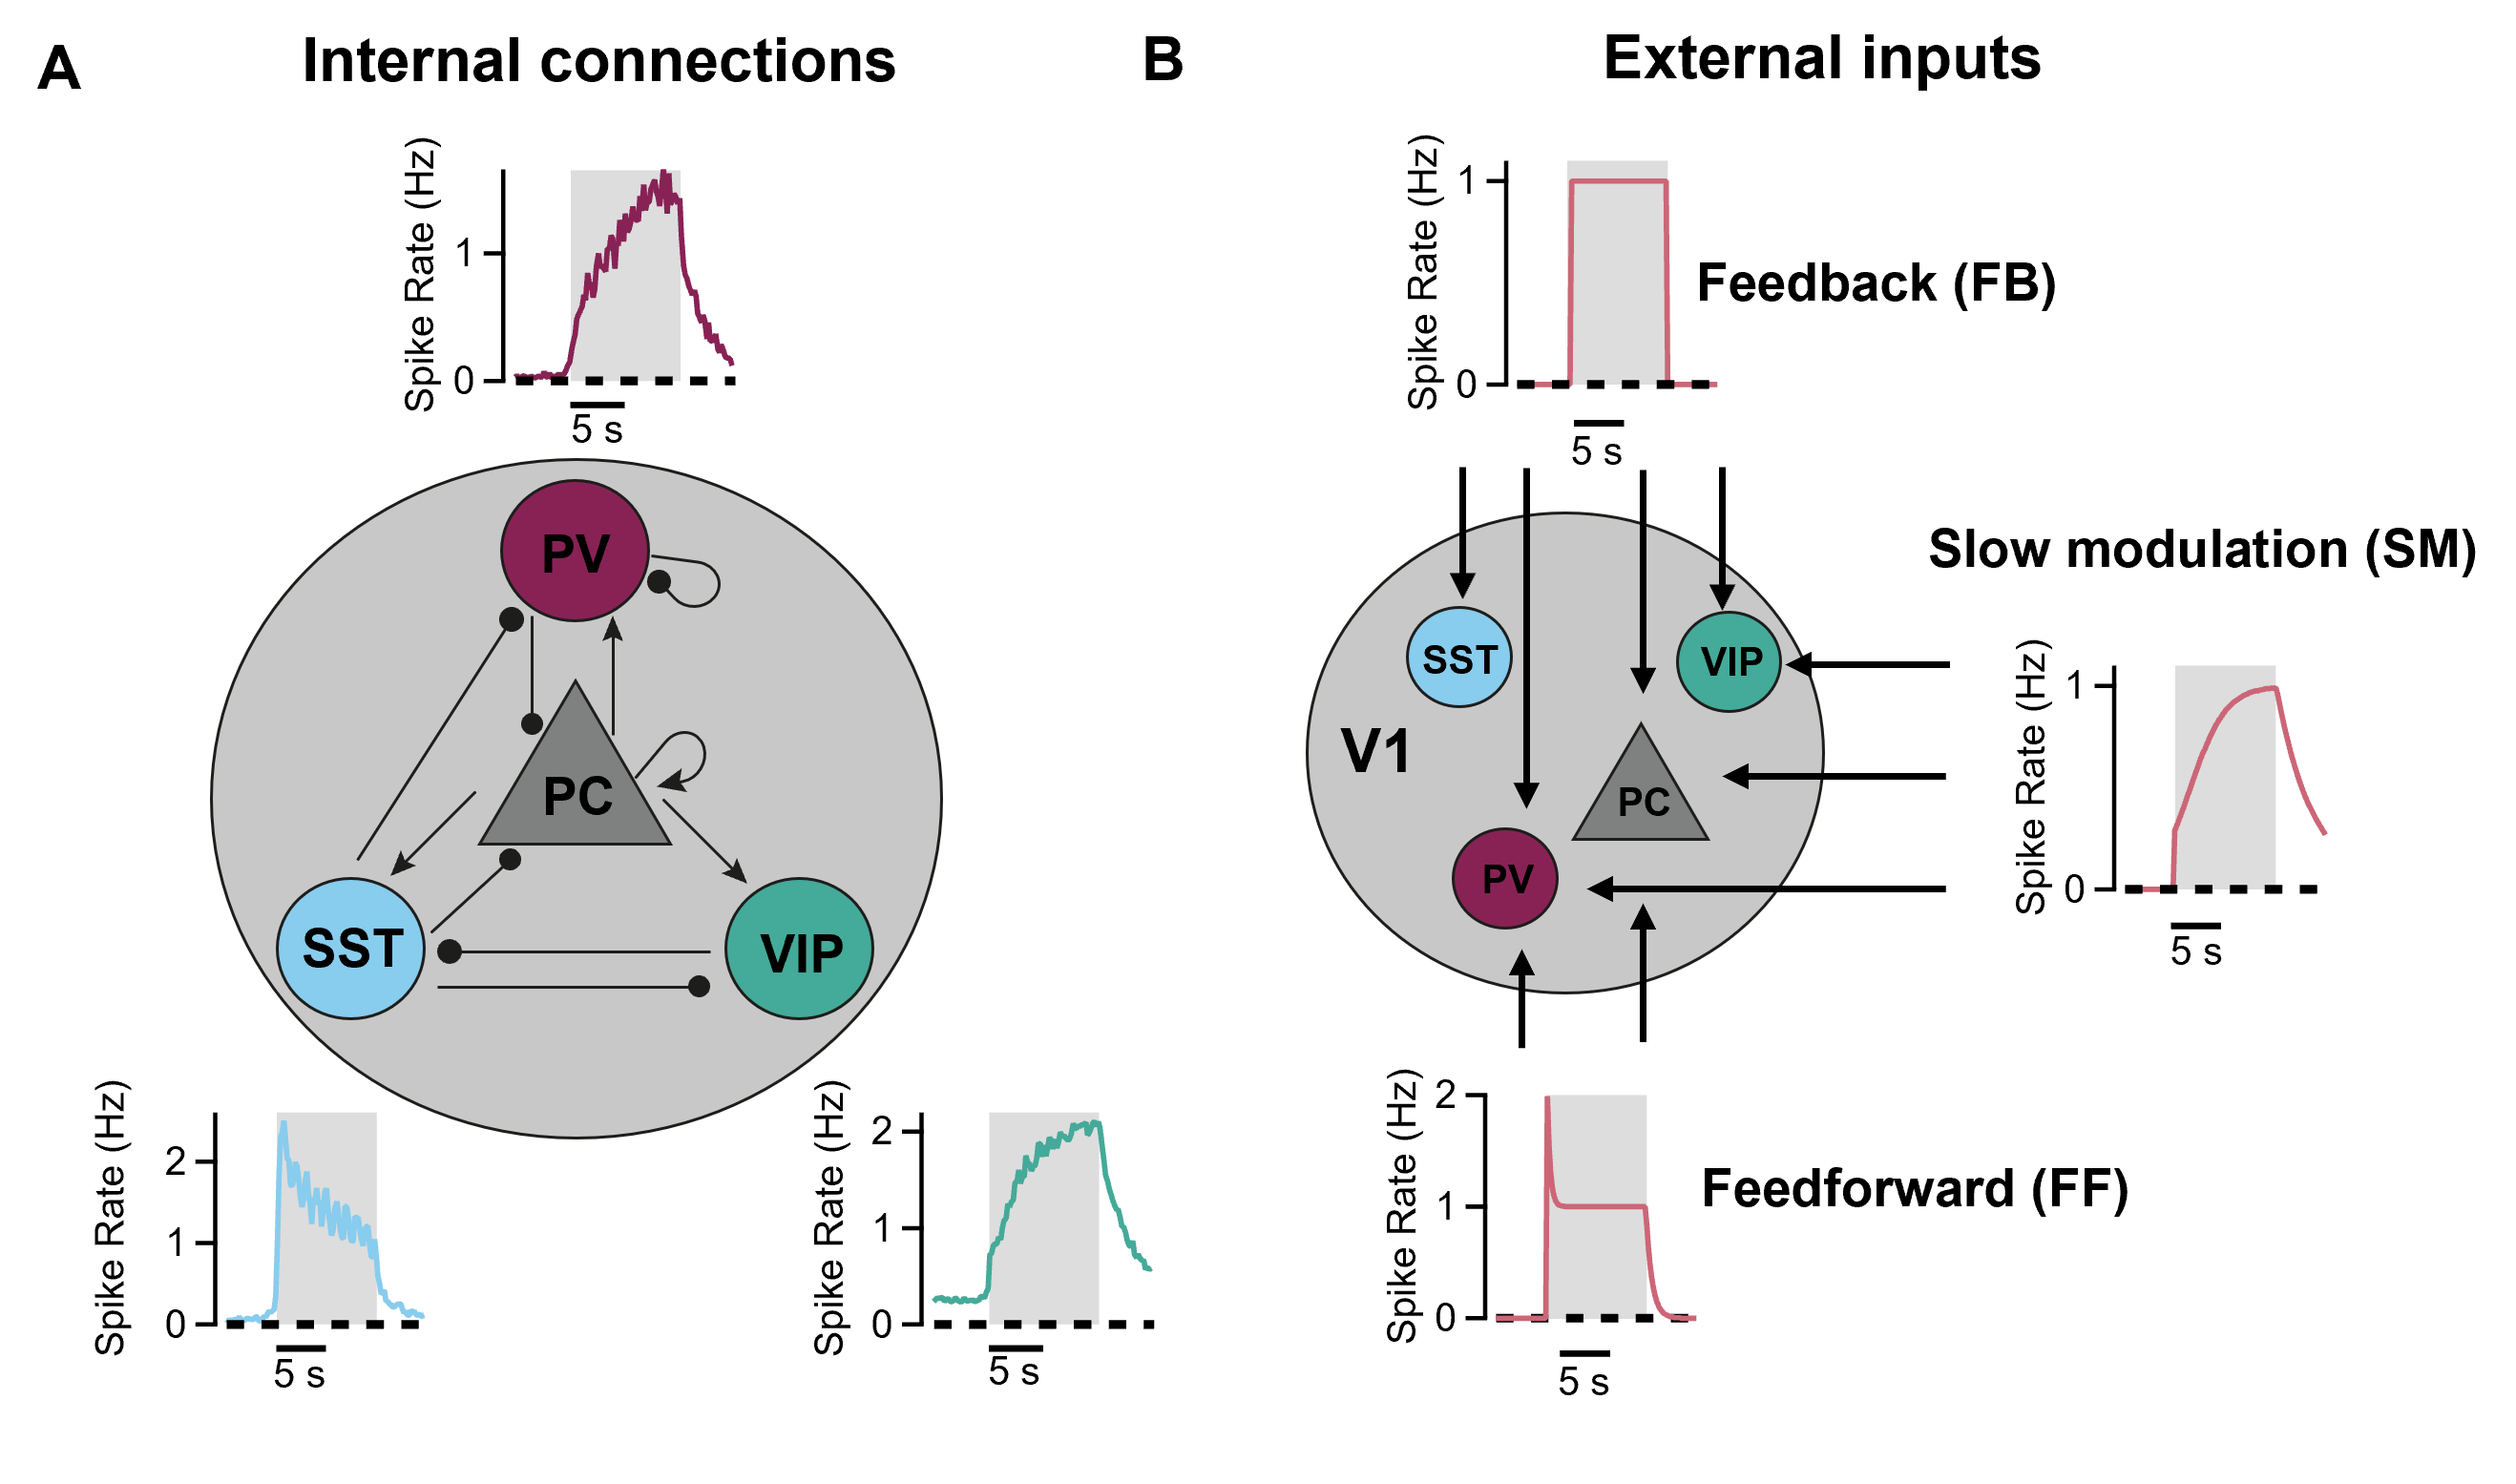

In [138]:
display.Image(r'Model_diagram.png')

In [139]:
# count = 0

# Functions

In [140]:
def Step(t, stim = 5, inter = 10, amp = 1.0, base = 0, k = 1, delay = 0, decay_f = 0):
    """
    Step-like output.
    """
    
    if (t < stim + delay):
        h = base
#     else:
#         if t < (stim + 1.5):
#             h = amp*1.25
    # elif (t > stim + inter):
    #     h = amp*np.exp(-(t - stim - inter)*decay_f) + base
    elif (t > stim + inter):
        h = amp * np.exp(-(t - stim - inter)*decay_f)
    else:
        h = amp*(t - stim - delay)*k*0.164745 + amp
    
    return h

In [141]:
def Step_1(t, stim = 5, k = 0, inter = 10, amp = 1.0, base = 1):
    """
    Step-like output.
    """
    
    if (t < stim) or (t > stim + inter):
        h = base
#     else:
#         if t < (stim + 1.5):
#             h = amp*1.25
    else:
        h = amp*(t - stim)*k*0.164745 + amp
    
    return h

In [142]:
def Sigm(t, stim = 5, inter = 10, ampl = 1.0, base = 0, rate = 1, delay = 0, decay_s = 1, dt = 0):
    """
    Step-like output.
    """
    
    if (t < stim):
        h = base
#     else:
#         if t < (stim + 1.5):
#             h = amp*1.25
    elif (t > stim + inter + dt):
        h = (base + (ampl/(1 + np.exp((delay-inter - dt)/rate))))*np.exp(-(t - stim - inter - dt)*decay_s) + base
    
    else:
        h = base + (ampl/(1 + np.exp((stim + delay - t)/rate))) #Actualy rate here is time constant, where 1/rate is actual rate
        
    
    return h

In [143]:
def expon(t, stim = 5, inter = 10, ampl = 1.5, base = 0, decay = 1, delay = 0, b = 0, decay_ff = 0, s_start = 0.1, k = 0.1):
    if (t < stim + delay):
        h = b
#     else:
#         if t < (stim + 1.5):
#             h = amp*1.25
    elif (t > stim + inter):
        h = (b + base + ampl*np.exp(-(inter-delay)*decay)+ (inter - delay - s_start)*k)*np.exp(-(t - stim - inter)*decay_ff)
    elif ((t >= stim + delay) and (t < stim + delay + s_start)):
        h = b + base + ampl*np.exp(-(t - stim - delay)*decay)
    else:
        h = b + base + ampl*np.exp(-(t - stim - delay)*decay)+ ((t - stim - delay - s_start)*k)
        
    return h

In [144]:
 def f_e_avg(t, data):
     """
    
     """    
    
     return np.interp(t, t_exp, data)

In [145]:
# def f_p(t, data):
#     """
    
#     """    
    
#     return np.interp(t, t_exp, data)

In [146]:
# def f_s(t):
#     """
    
#     """
    
#     return np.interp(t, t_exp, data_sst) 

In [147]:
# def f_v_f(t, data):
#     """
    
#     """    
    
#     return np.interp(t, t_exp, data)

In [148]:
# @jit(parallel=True, fastmath=True)
def model_step(t,
               y,
               w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18,
               tau_0, tau_1, tau_2, tau_3,
               threshold,
               power,
               q,
               i_0, i_1, i_2, i_3,
               r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k,
               i_d_0, w_d_0, w_d_1, w_d_2, w_d_3, w_d_4, w_d_5
               ):
    """
    Builds differential equation model of visual cortex network with step input h
    """
    
            
    f_e, f_p, f_s, f_v, f_e_o, f_p_o, f_s_o, f_v_o, f_e_d, f_e_do = y
    
    ff_e = (min(max((i_0 + w_0 * f_e + w_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_16 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_3 * f_p - w_4 * f_s), threshold), 25))
    ff_e_d = (min(max((i_d_0 + w_d_0 * f_e + w_d_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_d_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_d_3 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_d_4 * f_p - w_d_5 * f_s), threshold), 25))
    ff_p = (min(max((i_1 + w_17 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_5 * f_e + w_6 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_7 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) - w_8 * f_p - w_9 * f_s), threshold), 25))
    ff_s = (min(max((i_2 + w_10 * f_e + w_11 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_12 * f_v), threshold), 25))
    ff_v = (min(max((i_3 + w_18 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_13 * f_e - w_14 * f_s +  w_15 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm)), threshold), 25))
        
    ff_e_o = (min(max((i_0 + w_0 * f_e_o + w_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff) + w_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_16 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_3 * f_p_o - w_4 * f_s_o), threshold), 25))
    ff_e_do = (min(max((i_d_0 + w_d_0 * f_e_o + w_d_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_d_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_d_3 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_d_4 * f_p_o - w_d_5 * f_s_o), threshold), 25))
    ff_p_o = (min(max((i_1 + w_17 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_5 * f_e_o + w_6 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff) + w_7 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) - w_8 * f_p_o - w_9 * f_s_o), threshold), 25)) #*invpow_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.1, amp = 1, delta = 1) *Step_1(t, k=-0.2) Step_1(t, amp = 1.0, k=-0.13) exp_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.01, amp = 1) *invpow_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.1, amp = 1)
    ff_s_o = (min(max((i_2 + w_10 * f_e_o + w_11 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_12 * f_v_o), threshold), 25))
    ff_v_o = (min(max((i_3 + w_18 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_13 * f_e_o - w_14 * f_s_o +  w_15 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm)), threshold), 25))
    
        
    df_edt = ((q * ff_e ** power) - f_e) / tau_0
    df_e_ddt = ((q * ff_e_d ** power) - f_e_d) / tau_0
    df_pdt = ((q * ff_p ** power) - f_p) / tau_1
    df_sdt = ((q * ff_s ** power) - f_s) / tau_2
    df_vdt = ((q * ff_v ** power) - f_v) / tau_3
    
    if (t>=5): #and (t<=15):
        
        df_e_odt = ((q * (ff_e_o) ** power) - f_e_o) / tau_0
        df_e_dodt = ((q * ff_e_do ** power) - f_e_do) / tau_0
        df_p_odt = ((q * (ff_p_o*2.0) ** power) - f_p_o) / tau_1 #/1.5
        df_s_odt = ((q * (ff_s_o) ** power) - f_s_o) / tau_2 #/1.5
        df_v_odt = ((q * (ff_v_o) ** power) - f_v_o) / tau_3
        
    else:
        
        df_e_odt = ((q * (ff_e_o) ** power) - f_e_o) / tau_0
        df_e_dodt = ((q * ff_e_do ** power) - f_e_do) / tau_0
        df_p_odt = ((q * (ff_p_o) ** power) - f_p_o) / tau_1
        df_s_odt = ((q * (ff_s_o) ** power) - f_s_o) / tau_2
        df_v_odt = ((q * (ff_v_o) ** power) - f_v_o) / tau_3
    
#     dGdt = (- G + g * D * S) / tau_e
#     dDdt = (1 - D) / tau_d + D * np.log(d) * w_13 * Step(t, amp = 1.5, base = 0.0)
#     dSdt = (1 - S) / tau_s + S * np.log(s) *  w_13 * Step(t, amp = 1.5, base = 0.0)

    dydt = [df_edt, df_pdt, df_sdt, df_vdt, df_e_odt, df_p_odt, df_s_odt, df_v_odt, df_e_ddt, df_e_dodt]
    
    return dydt

In [149]:
names = ['w_PC_PC', # w_0
         'w_EX_PC', # w_1
         'w_SI_PC', # w_2
         'w_PV_PC', # w_3
         'w_SS_PC', # w_4
         'w_PC_PV', # w_5
         'w_EX_PV', # w_6
         'w_SI_PV', # w_7
         'w_PV_PV', # w_8
         'w_SS_PV', # w_9
         'w_PC_SS', # w_10
         'w_ST_SS', # w_11
         'w_VI_SS', # w_12
         'w_PC_VI', # w_13
         'w_SS_VI', # w_14
         'w_SI_VI', # w_15
         'w_ST_PC', # w_16
         'w_PC_PC', # w_17
         'w_PC_PC', # w_18
         'w_PC_PC', # w_19
         'w_PC_PC'] # w_20

In [150]:
#@njit(parallel=True, fastmath=True)
def exp_time(start, step, count, endpoint=False):
    """
    Returns NumPy array of experimental timepoints of data
    """
    stop = start+(step*count)
    return np.linspace(start, stop, count, endpoint=endpoint)

In [151]:
#@jit(parallel=True, fastmath=True)
def odesol_step(tt, init, params): 
    """
    Solves ODEs system for step input
    """
    y_init = init
    w_0 = params['w_0'].value
    w_1 = params['w_1'].value
    w_2 = params['w_2'].value
    w_3 = params['w_3'].value
    w_4 = params['w_4'].value
    w_5 = params['w_5'].value
    w_6 = params['w_6'].value
    w_7 = params['w_7'].value
    w_8 = params['w_8'].value
    w_9 = params['w_9'].value
    w_10 = params['w_10'].value
    w_11 = params['w_11'].value
    w_12 = params['w_12'].value
    w_13 = params['w_13'].value
    w_14 = params['w_14'].value
    w_15 = params['w_15'].value
    w_16 = params['w_16'].value
    w_17 = params['w_17'].value
    w_18 = params['w_18'].value
    
    tau_0 = params['tau_0'].value
    tau_1 = params['tau_1'].value
    tau_2 = params['tau_2'].value
    tau_3 = params['tau_3'].value
    threshold = params['threshold'].value
    power = params['power'].value
    q = params['q'].value
    i_0 = params['i_0'].value
    i_1 = params['i_1'].value
    i_2 = params['i_2'].value
    i_3 = params['i_3'].value
    ampl_1 = params['ampl_1'].value
#     ampl_2 = params['ampl_2'].value
#     ampl_3 = params['ampl_3'].value
#     kl = params['kl'].value
#     kl_1 = params['kl_1'].value
#     kl_2 = params['kl_2'].value
#     s_1 = params['s_1'].value
#     s_2 = params['s_2'].value
    r_1 = params['r_1'].value
    delay_1 = params['delay_1'].value
    delay_2 = params['delay_2'].value
    delay_3 = params['delay_3'].value
    decay = params['decay'].value
    decay_s = params['decay_s'].value
    decay_f = params['decay_f'].value
    decay_ff = params['decay_ff'].value
    ampl = params['ampl'].value
    base = params['base'].value
    base_sigm = params['base_sigm'].value
    s_start = params['s_start'].value
    k = params['k'].value

    i_d_0 = params['i_d_0'].value
    w_d_0 = params['w_d_0'].value
    w_d_1 = params['w_d_1'].value
    w_d_2 = params['w_d_2'].value
    w_d_3 = params['w_d_3'].value
    w_d_4 = params['w_d_4'].value
    w_d_5 = params['w_d_5'].value
   
    
    
    sol = solve_ivp(lambda t, y: model_step(t, y, 
                                            w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                                            tau_0, tau_1, tau_2, tau_3,
                                            threshold,
                                            power, 
                                            q,
                                            i_0, i_1, i_2, i_3,
                                            r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k,
                                            i_d_0, w_d_0, w_d_1, w_d_2, w_d_3, w_d_4, w_d_5
                                           ), 
                    [tt[0], tt[-1]],
                    y_init,
                    method='RK45',
                    t_eval=tt,
                    #rtol = 1e-10, atol = 1e-12
                   )
    
    
    return sol

In [152]:
def simulate_step(tt, init, params):
    """
    Simulates model
    """

    sol = odesol_step(tt, init, params)
    
    dd = np.vstack((sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4], sol.y[5], sol.y[6], sol.y[7], sol.y[8], sol.y[9])).T
    sim = pd.DataFrame(dd, columns=['t', 'f_e', 'f_pv', 'f_sst', 'f_vip', 'f_e_o', 'f_pv_o', 'f_sst_o', 'f_vip_o', 'f_e_d', 'f_e_do'])
    
    return sim

In [153]:
def residual_ad(params, tt, init, data_pc_sen):
    """
    Difference between model and data for further minimization
    """
    global count, max_nfev

    weights_pc = np.float32(np.zeros_like(data_pc_sen))
    weights_pc[0:24] = 1.
    weights_pc[24:30] = 0.05
    weights_pc[30:38] = 1.
    weights_pc[38:] = 1.
    
    model = simulate_step(tt, init, params)
    pc_d_r = (np.array(model['f_e_d'].values - data_pc_sen)*weights_pc).ravel() #/np.array(pc_sen_err_new)
    
    display.clear_output(wait=True)
    plt.figure(figsize = (15,5))
    plt.plot(t_exp, data_pc_sen, color='black', marker='o', label='f_pc(t)')
    plt.plot(t_exp, model['f_e_d'].values, color='blue', label='fit', linewidth=3)
    plt.title('leastsq_PC')
    plt.legend(loc='best')
    plt.xlabel('t')
    #plt.ylim(0, 1.2)
    plt.xticks(np.arange(0,21,1))
    plt.grid()
    text = str(count) + ' ' + '/' + ' ' + str(max_nfev) 
    
    bbox = dict(boxstyle='round', fc='white', ec='orange', alpha=0.5)
    plt.text(20.6, 0.45, text, fontsize=12, bbox=bbox, horizontalalignment='right')
    count += 1
    
    plt.show()
    
    return pc_d_r

In [154]:
def RMSE_full(params, init, data_pc, data_pv, data_sst, data_vip):

    model = simulate_step(t_exp, init, params)
    sum = 0
    for i in range(len(data_pc)):
        sum += (model['f_e'].values[i] - data_pc[i])**2 + (model['f_pv'].values[i] - data_pv[i])**2 + (model['f_sst'].values[i] - data_sst[i])**2 + (model['f_vip'].values[i] - data_vip[i])**2

    sum = np.sqrt((sum)/(len(data_pc)*4))

    return sum

In [155]:
def RMSE(params, init, data, type):

    model = simulate_step(t_exp, init, params)
    sum = 0
    for i in range(len(data)):
        sum += (model[type].values[i] - data[i])**2

    sum = np.sqrt((sum)/len(data))

    return sum

# Experimental data

In [156]:
pc_sen = np.loadtxt(r'Experimental data\Updated_again\CC_QA_Norx2_Sen_Avg1_Loco.txt')
pc_dep = np.loadtxt(r'Experimental data\Updated_again\CC_QA_Norx2_Dep_Avg1_Loco.txt')
#f_e_exp_3 = np.loadtxt(r'Experimental data\Updated_again\PC_AllFil_Sess1_firingrate_10_11_2023.txt')
pc_na = np.loadtxt(r'Experimental data\Updated_again\CC_QA_Norx2_NA_Avg1_Loco.txt')
pc_all = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PC_All_AvgSess1.txt')
pc_sen_err = np.loadtxt(r'Experimental data\Updated_again\C_QA_Norx2_Sen_SEM1_Loco.txt')
pc_dep_err = np.loadtxt(r'Experimental data\Updated_again\C_QA_Norx2_Dep_SEM1_Loco.txt')
pc_na_err = np.loadtxt(r'Experimental data\Updated_again\C_QA_Norx2_NA_SEM1_Loco.txt')
pc_opto_pv_arch = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_PVArChT1_Opto.txt')
pc_opto_pv_chr = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_PVChR1_Opto.txt')
pc_opto_sst_arch = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_SSTArchT1_Opto.txt')
pc_opto_sst_chr = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_SSTChR1_Opto.txt')
pc_all_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PC_All_SEMSess1.txt')
#print(f_e_exp_1)
t_exp_1 = exp_time(start=0.0, step=0.164745, count=len(pc_sen))
#print(t_exp_1)
print(len(pc_sen), len(t_exp_1))

183 183


In [157]:
pv = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PV_AvgSess.txt')
pv_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PV_SEMSess.txt')
#print(f_e_exp_1)
t_pv_exp_1 = exp_time(start=0.0, step=0.164745, count=len(pv))
#print(t_exp_1)
print(len(pv), len(t_pv_exp_1))

183 183


In [158]:
# pv_new = f_pv_exp_1[0:122]
# t_ca_new = t_pv_exp_1[0:122]
# plt.plot(t_ca_new, pv_new, marker = 'x', label = 'pv', color='orange')
# plt.legend()
# plt.show()

In [159]:
# a = [f_pv_exp_1[121]]
# b = [t_pv_exp_1[121]]
# c = []
# for i in range(0,61):
#     a.append(a[-1]*np.exp(-1.0392*0.164745))
#     b.append(b[-1] + 0.164745)

# for i in t_exp_1:
#     c.append(Step(i, stim = 5, amp = 0.5, base = 0.0))
    

# pv_new = np.append(pv_new, a)
# t_ca_new = np.append(t_ca_new, b)

# plt.plot(t_exp_1, f_e_exp_4, marker = 'x', label = 'pc_avg')
# plt.plot(t_exp_1, f_pv_exp_1, marker = 'x', label = 'pv_old')
# plt.plot(t_exp_1, c)
# plt.plot(t_ca_new, pv_new, marker = 'x', label = 'pv_new')
# plt.legend()
# plt.show()

In [160]:
sst = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_SST_AvgSess.txt')
sst_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_SST_SEMSess.txt')
#print(f_e_exp_1)
t_sst_exp_1 = exp_time(start=0.0, step=0.164745, count=len(sst))
#print(t_exp_1)
print(len(sst), len(t_sst_exp_1))

183 183


In [161]:
vip = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_VIP_AvgSess.txt')
vip_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_VIP_SEMSess.txt')
#print(f_e_exp_1)
t_vip_exp_1 = exp_time(start=0.0, step=0.164745, count=len(vip))
#print(t_exp_1)
print(len(vip), len(t_vip_exp_1))

183 183


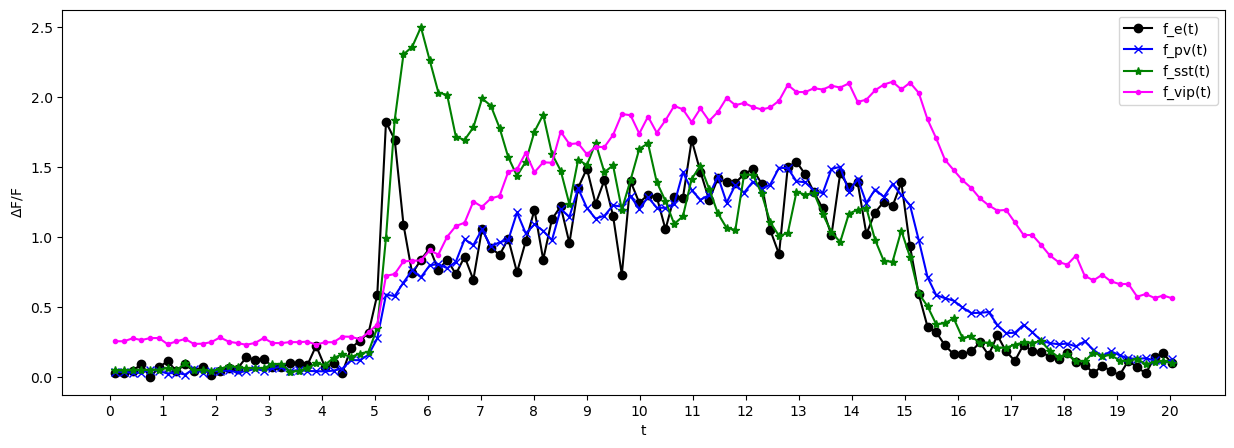

In [162]:
dt = 0.164745

t_exp_1_new = []
pc_sen_new = []
#f_e_avg_l = []
pv_new = []
#f_pv_excite = []
sst_new = []
vip_new = []
pc_na_new = []
pc_dep_new = []
pc_all_new = []
pc_sen_err_new = []
pc_dep_err_new = []
pc_na_err_new = []
pc_all_err_new = []
pv_err_new = []
sst_err_new = []
vip_err_new = []
pc_opto_pv_arch_new = []
pc_opto_pv_chr_new = []
pc_opto_sst_chr_new = []
pc_opto_sst_arch_new = []

for ind, time in np.ndenumerate(t_exp_1):
    if (time >= 5) and (time <= 25):
        t_exp_1_new.append(time - 5)
        pc_sen_new.append(pc_sen[ind])
        #f_e_avg_l.append(f_e_exp_3[ind])
        pv_new.append(pv[ind])
        sst_new.append(sst[ind])
        vip_new.append(vip[ind])
        pc_na_new.append(pc_na[ind])
        pc_dep_new.append(pc_dep[ind])
        pc_all_new.append(pc_all[ind])
        #f_pv_excite.append(pv_new[ind])
        pc_sen_err_new.append(pc_sen_err[ind])
        pc_dep_err_new.append(pc_dep_err[ind])
        pc_na_err_new.append(pc_na_err[ind])
        pv_err_new.append(pv_err[ind])
        sst_err_new.append(sst_err[ind])
        vip_err_new.append(vip_err[ind])
        pc_opto_pv_arch_new.append(pc_opto_pv_arch[ind])
        pc_opto_pv_chr_new.append(pc_opto_pv_chr[ind])
        pc_opto_sst_chr_new.append(pc_opto_sst_chr[ind])
        pc_opto_sst_arch_new.append(pc_opto_sst_arch[ind])
        pc_all_err_new.append(pc_all_err[ind])
        
        
pc_sen_new.insert(0, pc_sen_new[0])
pv_new.insert(0, pv_new[0])
sst_new.insert(0, sst_new[0])
vip_new.insert(0, vip_new[0])
pc_na_new.insert(0, pc_na_new[0])
pc_dep_new.insert(0, pc_dep_new[0])
pc_all_new.insert(0, pc_all_new[0])
pc_sen_err_new.insert(0, pc_sen_err_new[0])
pc_dep_err_new.insert(0, pc_dep_err_new[0])
pc_na_err_new.insert(0, pc_na_err_new[0])
pv_err_new.insert(0, pv_err_new[0])
sst_err_new.insert(0, sst_err_new[0])
vip_err_new.insert(0, vip_err_new[0])
pc_opto_pv_arch_new.insert(0, pc_opto_pv_arch_new[0])
pc_opto_pv_chr_new.insert(0, pc_opto_pv_chr_new[0])
pc_opto_sst_chr_new.insert(0, pc_opto_sst_chr_new[0])
pc_opto_sst_arch_new.insert(0, pc_opto_sst_arch_new[0])
pc_all_err_new.insert(0, pc_all_err_new[0])

#t_exp_1_new = np.linspace(start=0, stop=(len(pc_sen_new)-1)*dt, num=len(pc_sen_new))
t_exp_1_new.append(t_exp_1_new[-1] + dt)
        
plt.figure(figsize=(15,5))
plt.plot(t_exp_1_new, pc_sen_new, color='black', marker='o', label='f_e(t)')
plt.plot(t_exp_1_new, pv_new, color='blue', marker='x', label='f_pv(t)')
plt.plot(t_exp_1_new, sst_new, color='green', marker='*', label='f_sst(t)')
plt.plot(t_exp_1_new, vip_new, color='magenta', marker='.', label='f_vip(t)')
#plt.plot(t_exp_1_new, f_pv_excite, color='orange', marker='v', label='external')

plt.legend(loc='best')
plt.ylabel(r'$\Delta$F/F')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

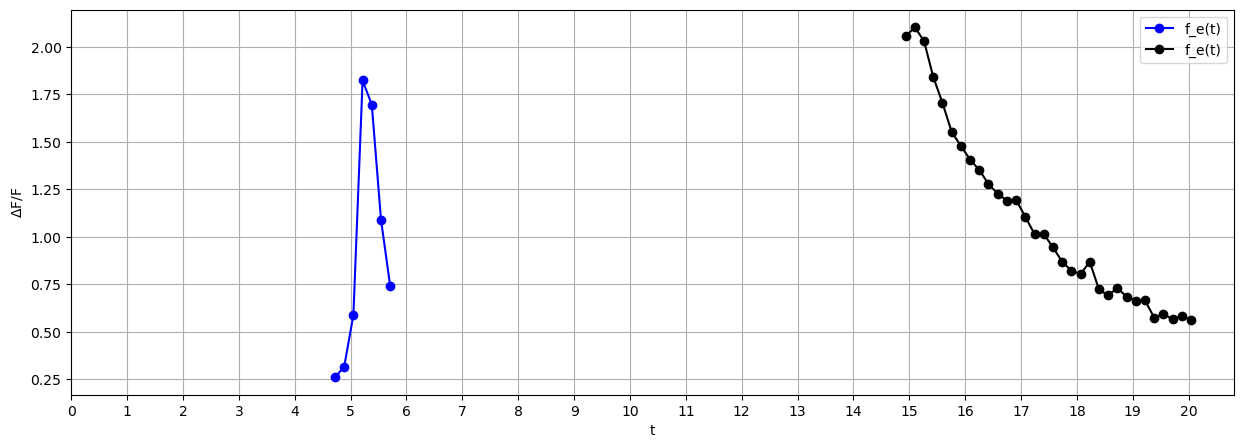

In [163]:
plt.figure(figsize=(15,5))
plt.plot(t_exp_1_new[28:35], pc_sen_new[28:35], color='blue', marker='o', label='f_e(t)')
plt.plot(t_exp_1_new[90:], vip_new[90:], color='black', marker='o', label='f_e(t)')

plt.legend(loc='best')
plt.ylabel(r'$\Delta$F/F')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,21,1))
plt.grid()
plt.show()

# Variables and constants

In [164]:
# print("SEN_avg = ", np.float32(np.array(pc_sen_new))[:].mean())
# print("ALL_avg = ", np.float32(np.array(pc_all_new))[:].mean())

# scale = np.sqrt(np.float32(np.array(pc_sen_new))[:].mean()/np.float32(np.array(pc_all_new))[:].mean())
# # heat_new = pd.DataFrame()
# # heat_new[''] = ['PC', 'PV', 'SST', 'VIP', 'FF', 'SM', 'FB']
# # heat_new['PC_SEN'] = [params["w_d_0"].value / scale,
# #                   params["w_d_4"].value / scale,
# #                   params["w_d_5"].value / scale,
# #                   None,
# #                   params["w_d_1"].value / scale,
# #                   params["w_d_2"].value / scale,
# #                   params["w_d_3"].value / scale]
# # heat_new.set_index('', inplace = True)
# #date = datetime.datetime.now().date()
# #heat_new.to_excel(f'weights_sen_{date}.xlsx')

# print("Scale = ", scale)
# #heat_new

In [165]:
print("SEN_avg = ", np.float32(np.array(pc_sen_new))[30:90].mean())
print("ALL_avg = ", np.float32(np.array(pc_all_new))[30:90].mean())

scale = np.sqrt(np.float32(np.array(pc_sen_new))[30:90].mean()/np.float32(np.array(pc_all_new))[30:90].mean())
# heat_new = pd.DataFrame()
# heat_new[''] = ['PC', 'PV', 'SST', 'VIP', 'FF', 'SM', 'FB']
# heat_new['PC_SEN'] = [params["w_d_0"].value / scale,
#                   params["w_d_4"].value / scale,
#                   params["w_d_5"].value / scale,
#                   None,
#                   params["w_d_1"].value / scale,
#                   params["w_d_2"].value / scale,
#                   params["w_d_3"].value / scale]
# heat_new.set_index('', inplace = True)
#date = datetime.datetime.now().date()
#heat_new.to_excel(f'weights_sen_{date}.xlsx')

print("Scale = ", scale)
#heat_new

SEN_avg =  1.175745
ALL_avg =  0.9640347
Scale =  1.1043589


In [166]:
t = np.float32(np.array(t_exp_1_new))
t_exp = t
threshold = np.float32(0) 

power = np.float32(2.0)
q = np.float32(1.0)

ampl_1 = 1.0
# ampl_2 = 5.0
# ampl_3 = 0
# kl = 0
# kl_1 = 0
# kl_2 = 0
# s_1 = 0.10
# s_2 = 0.10

r_1 = np.float32(1.71393899)
delay_1 = np.float32(0.16504184)
delay_2 = np.float32(1.73304975)
delay_3 = np.float32(0.36952741)
decay = np.float32(3.32408909)
decay_s = np.float32(0.26854964)
decay_f = np.float32(0.83425024)
decay_ff = np.float32(2.15272213)
ampl = np.float32(1.02696097)
base = np.float32(1.0)
base_sigm = np.float32(0)
s_start = np.float32(0.18358839)
k = np.float32(0.03068755)

init = np.float32(np.array([0.055, 0.011, 0.017, 0.208, 0.055, 0.011, 0.017, 0.208, 0.0296, 0.0296]))
tau = np.float32(np.array([0.015, 0.0075, 0.019, 0.019]))
#tau_s = np.array([100, 1, 15, 0.5])
i = np.float32(np.array([0.26580502, 0.01447602, 0.11203215, 0.51341198]))
w = np.float32(np.array([
              0.08281103, # w_0  PC  -> PC        
              1.51969985, # w_1  FF  -> PC
              1.06618999, # w_2  SM   -> PC
              1.95560664, # w_3  PV -> PC
              0.63190096, # w_4  SST  -> PC
              0.20723919, # w_5  PC   -> PV
              0.92636845, # w_6  FF  -> PV
              2.11169434, # w_7  SM -> PV
              1.51029559, # w_8  PV   -> PV
              0.25013329, # w_9  SST  -> PV
              0.78370724, # w_10 PC -> SST
              0.59415933, # w_11 FB  -> SST
              0.14997032, # w_12 VIP  -> SST
              0.32398988, # w_13 PC  -> VIP
              0.19112577, # w_14 SST  -> VIP
              0.73762300, # w_15 SM  -> VIP
              1.14600083, # w_16 FB  -> PC
              0.17580747, # w_17 FB  -> PV
              0.15806817]))# w_18 FB -> VIP

i_d = np.array([i[0] * scale])

w_d = np.array([w[0] * scale, # w_d_0  PC  -> PC        
                1.519 * scale, # w_d_1  FF  -> PC
                1.066 * scale, # w_d_2  SM   -> PC
                1.146 * scale, # w_d_3  FB   -> PC
                1.798 * scale, # w_d_4  PV   -> PC
                0.766 * scale]) # w_d_5  SST -> PC


# g = 1
# d = 0.9478
# s = 0.9999
# tau_d = 0.4429
# tau_s = 13.8823
# tau_e = 2e-3

data_pc_sen = np.float32(np.array(pc_sen_new)) #* 0.333 #proportion of cells relative to PC
#data_pc_avg = f_e_avg_l
data_pv = np.float32(np.array(pv_new)) #proportion of cells relative to PC
data_sst = np.float32(np.array(sst_new)) #proportion of cells relative to PC
data_vip = np.float32(np.array(vip_new)) #proportion of cells relative to PC
data_pc_na = np.float32(np.array(pc_na_new)) #* 0.333 #proportion of cells relative to PC
data_pc_dep = np.float32(np.array(pc_dep_new)) #* 0.333 #proportion of cells relative to PC
data_pc_all = np.float32(np.array(pc_all_new))
data_pc_opto_pv_arch = np.float32(np.array(pc_opto_pv_arch_new))
data_pc_opto_pv_chr = np.float32(np.array(pc_opto_pv_chr_new))
data_pc_opto_sst_chr = np.float32(np.array(pc_opto_sst_chr_new))
data_pc_opto_sst_arch = np.float32(np.array(pc_opto_sst_arch_new))
pv_err_new = np.array(pv_err_new)
sst_err_new = np.array(sst_err_new)
vip_err_new = np.array(vip_err_new)

#data_pv_exc = f_pv_excite

count = 0
max_nfev = 2000

In [167]:
print(len(data_pc_sen))

122


## Parameters

In [168]:
params = Parameters()
params.add('w_0', value = w[0] , vary = False, min = 0.0, max = 5)
params.add('w_1', value = w[1] , vary = False, min = 0.0, max = 5)
params.add('w_2', value = w[2] , vary = False, min = 0.0, max = 5)
params.add('w_3', value = w[3] , vary = False, min = 0.0, max = 5)
params.add('w_4', value = w[4] , vary = False, min = 0.0, max = 5)
params.add('w_5', value = w[5] , vary = False, min = 0.0, max = 5)
params.add('w_6', value = w[6] , vary = False, min = 0.0, max = 5)
params.add('w_7', value = w[7] , vary = False, min = 0.0, max = 5)
params.add('w_8', value = w[8] , vary = False, min = 0.0, max = 5)
params.add('w_9', value = w[9] , vary = False, min = 0.0, max = 5)
params.add('w_10', value = w[10] , vary = False, min = 0.0, max = 5)
params.add('w_11', value = w[11] , vary = False, min = 0.0, max = 5)
params.add('w_12', value = w[12] , vary = False, min = 0.0, max = 5)
params.add('w_13', value = w[13] , vary = False, min = 0.0, max = 5)
params.add('w_14', value = w[14] , vary = False, min = 0.0, max = 5)
params.add('w_15', value = w[15] , vary = False, min = 0.0, max = 5)
params.add('w_16', value = w[16] , vary = False, min = 0.0, max = 5)
params.add('w_17', value = w[17] , vary = False, min = 0.0, max = 5)
params.add('w_18', value = w[18] , vary = False, min = 0.0, max = 5)

#params.add('w_13', value = w[13] , vary = True, min = 0.1, max = 25)
params.add('tau_0', value = tau[0] , vary = False, min = 0.001, max = 0.03)
params.add('tau_1', value = tau[1] , vary = False, min = 0.001, max = 0.03)
params.add('tau_2', value = tau[2] , vary = False, min = 0.001, max = 0.03)
params.add('tau_3', value = tau[3] , vary = False, min = 0.001, max = 0.03)
params.add('threshold', value = threshold , vary = False, min = -np.inf, max = np.inf)
params.add('power', value = power , vary = False, min = 0, max = 3.5)
params.add('q', value = q, vary = False, min = 0.001, max = 2.5 )
params.add('i_0', value = i[0] , vary = False, min = 0.0, max = 1.5)
params.add('i_1', value = i[1] , vary = False, min = 0.0, max = 1.5)
params.add('i_2', value = i[2] , vary = False, min = 0.0, max = 1.5)
params.add('i_3', value = i[3] , vary = False, min = 0.0, max = 1.5)

params.add('ampl_1', value = ampl_1 , vary = False, min = 0.0, max = 10)

params.add('i_d_0', value = i_d[0] , vary = False, min = 0, max = 5)
params.add('w_d_0', value = w_d[0] , vary = False, min = 0, max = 5)
params.add('w_d_1', value = w_d[1] , vary = True, min = 0.9 * w_d[1], max = 1.1 * w_d[1])
params.add('w_d_2', value = w_d[2] , vary = True, min = 0.9 * w_d[2], max = 1.1 * w_d[2])
params.add('w_d_3', value = w_d[3] , vary = True, min = 0.9 * w_d[3], max = 1.1 * w_d[3])
params.add('w_d_4', value = w_d[4] , vary = True, min = 0, max = 5)
params.add('w_d_5', value = w_d[5] , vary = True, min = 0, max = 5)

params.add('r_1', value = r_1, vary = False, min = 0, max = 5)
params.add('delay_1', value = delay_1, vary = False, min = 0, max = 1.5)
params.add('delay_2', value = delay_2, vary = False, min = 0, max = 25)
params.add('delay_3', value = delay_3, vary = False, min = 0, max = 3)
params.add('decay', value = decay, vary = False, min = 0, max = 10)
params.add('decay_s', value = decay_s, vary = False, min = 0, max = 10)
params.add('decay_f', value = decay_f, vary = False, min = 0, max = 10)
params.add('decay_ff', value = decay_ff, vary = False, min = 0, max = 10)
params.add('ampl', value = ampl, vary = False, min = 0, max = 5)
params.add('base', value = base, vary = False, min = 0, max = 5)
params.add('base_sigm', value = base_sigm, vary = False, min = 0, max = 2)
params.add('s_start', value = s_start, vary = False, min = 0, max = 4)
params.add('k', value = k, vary = False, min = 0.03, max = 2)

params

name,value,initial value,min,max,vary
w_0,0.08281103,0.08281102776527405,0.00000000,5.00000000,False
w_1,1.51969981,1.5196998119354248,0.00000000,5.00000000,False
w_2,1.06619000,1.0661900043487549,0.00000000,5.00000000,False
w_3,1.95560670,1.9556066989898682,0.00000000,5.00000000,False
w_4,0.63190097,0.63190096616745,0.00000000,5.00000000,False
w_5,0.20723920,0.20723919570446014,0.00000000,5.00000000,False
w_6,0.92636847,0.9263684749603271,0.00000000,5.00000000,False
w_7,2.11169434,2.1116943359375,0.00000000,5.00000000,False
w_8,1.51029563,1.5102956295013428,0.00000000,5.00000000,False
w_9,0.25013328,0.2501332759857178,0.00000000,5.00000000,False


In [169]:
#print(f_s(t_exp[1]))

In [170]:
# scale = 0.9847
# heat_new = pd.DataFrame()
# heat_new[''] = ['PC', 'PV', 'SST', 'VIP', 'FF', 'SM', 'FB']
# heat_new['PC_SEN'] = [params["w_d_0"].value * scale,
#                   params["w_d_4"].value * scale,
#                   params["w_d_5"].value * scale,
#                   None,
#                   params["w_d_1"].value * scale,
#                   params["w_d_2"].value * scale,
#                   params["w_d_3"].value * scale]
# heat_new.set_index('', inplace = True)
# date = datetime.datetime.now().date()
# heat_new.to_excel(f'weights_sen_{date}.xlsx')
# heat_new

In [171]:
print(len(t_exp), t_exp)

122 [ 0.107095  0.27184   0.436585  0.60133   0.766075  0.93082   1.095565
  1.26031   1.425055  1.5898    1.754545  1.91929   2.084035  2.24878
  2.413525  2.57827   2.743015  2.90776   3.072505  3.23725   3.401995
  3.56674   3.731485  3.89623   4.060975  4.22572   4.390465  4.55521
  4.719955  4.8847    5.049445  5.21419   5.378935  5.54368   5.708425
  5.87317   6.037915  6.20266   6.367405  6.53215   6.696895  6.86164
  7.026385  7.19113   7.355875  7.52062   7.685365  7.85011   8.014855
  8.1796    8.344345  8.50909   8.673835  8.83858   9.003325  9.16807
  9.332815  9.49756   9.662305  9.82705   9.991795 10.15654  10.321285
 10.48603  10.650775 10.81552  10.980265 11.14501  11.309755 11.4745
 11.639245 11.80399  11.968735 12.13348  12.298225 12.46297  12.627715
 12.79246  12.957205 13.12195  13.286695 13.45144  13.616185 13.78093
 13.945675 14.11042  14.275165 14.43991  14.604655 14.7694   14.934145
 15.09889  15.263635 15.42838  15.593125 15.75787  15.922615 16.08736
 16.252106

In [172]:
#model = simulate_step(t_exp, init, params)
#print(model, 2*'\n', len(model))

In [173]:
# plt.plot(model['t'], model['f_e'])
# plt.ylim(0,5)
# plt.show()

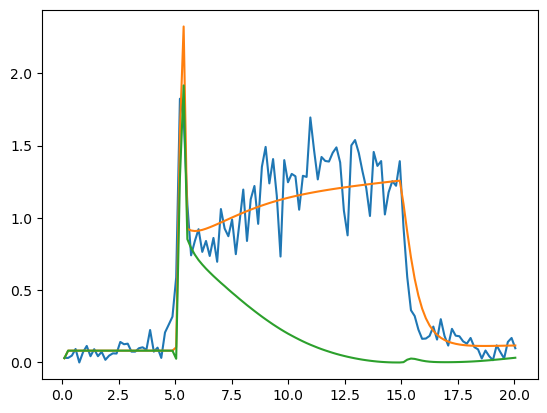

In [174]:
model = simulate_step(t_exp, init, params)
plt.plot(t_exp, data_pc_sen)
plt.plot(t_exp, model["f_e_d"])
plt.plot(t_exp, model["f_e_do"])

In [175]:
# #display(HTML(model[['t', 'f_e_d']].to_html()))
model[['t', 'f_e_d']].to_csv(f'C_trace_s1_hab_Loco_SEN_{datetime.datetime.now().date()}.csv', index=False)
# model[['t', 'f_e_do']].to_csv(f'out_sen_pv_arch_{datetime.datetime.now().date()}.csv', index=False)

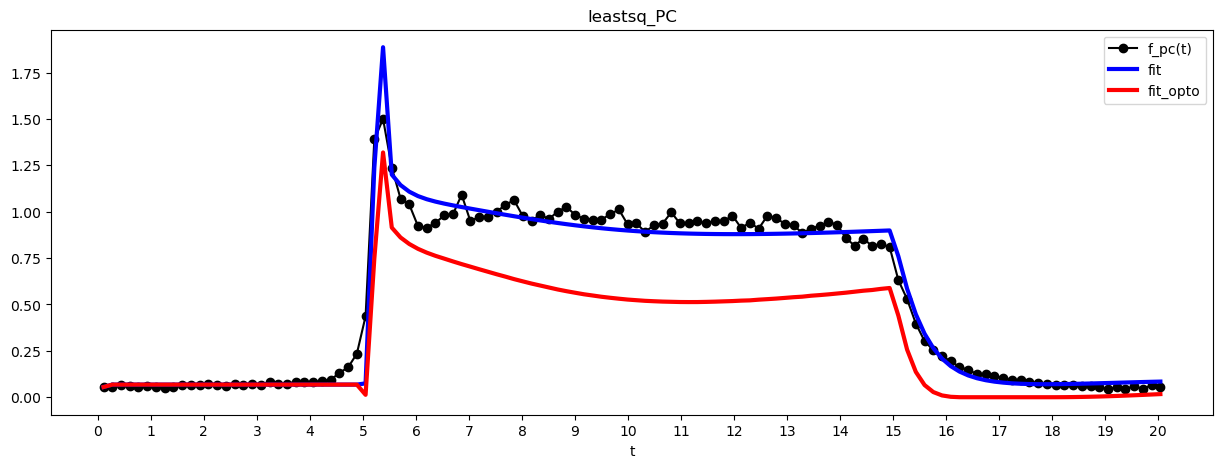

In [41]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_e_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

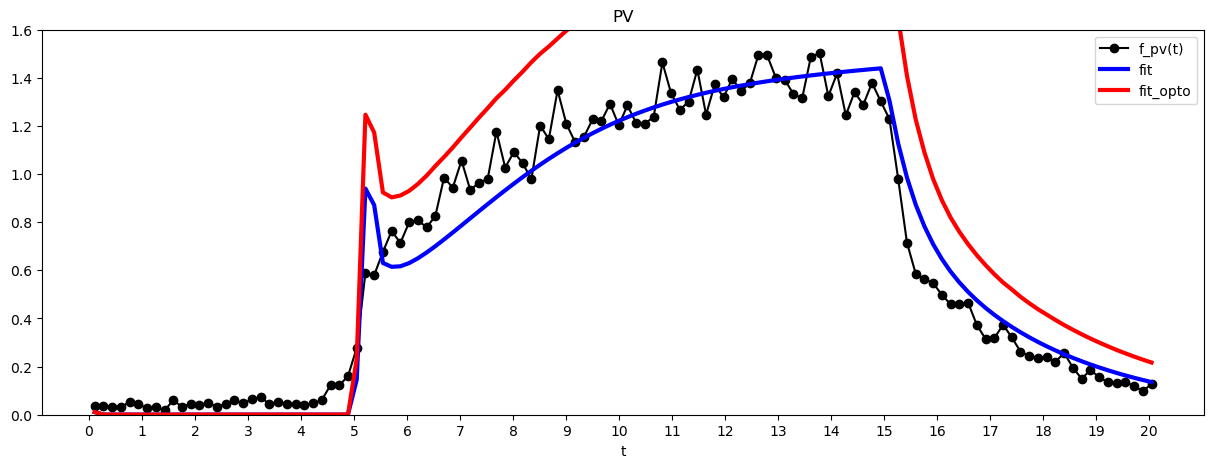

In [42]:
plt.figure(figsize=(15,5))
fast = []
slow = []
for i in t_exp:
    fast.append(0.33181904 * expon(i, ampl = 2.21679020, base = 2.8, decay = 2.86514393, delay = 0.02399650))
    slow.append(0.62204067 * Sigm(i, rate = 1.46386253, delay = 2.37599864))

plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, data_pc_all, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, fast, color='green', label='fit', linewidth=3)
#plt.plot(t_exp, slow, color='orange', label='fit', linewidth=3)
plt.plot(t_exp, model['f_pv'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_pv_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

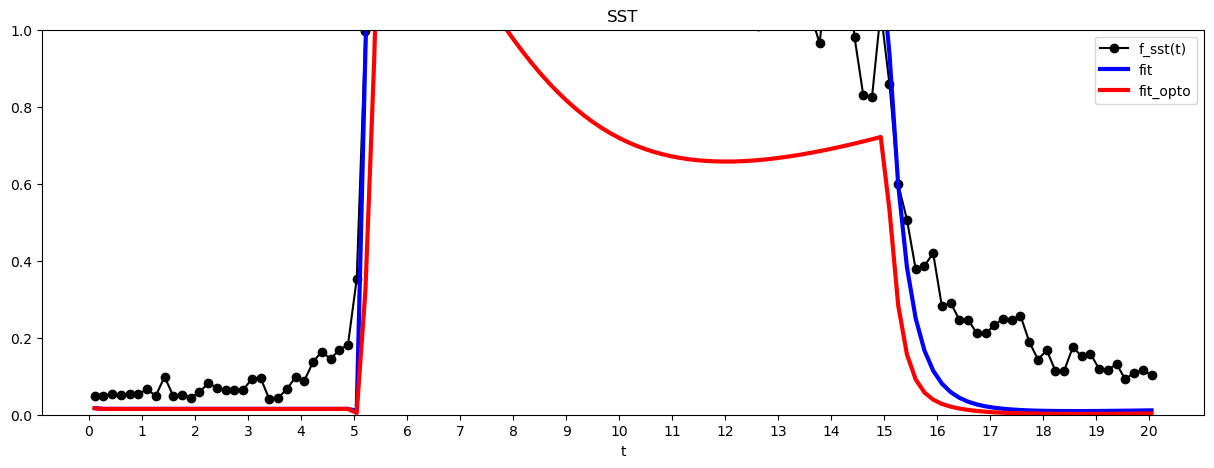

In [43]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, model['f_sst'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_sst_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.0)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

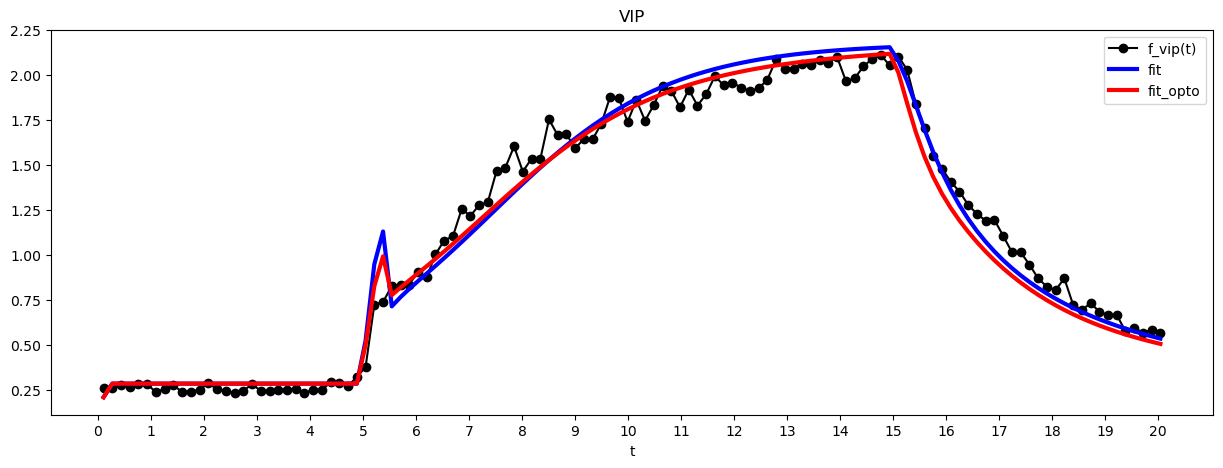

In [44]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, model['f_vip'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_vip_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 2.2)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

# Solve

## leastsq (Levenberg-Marquardt)

In [45]:
count = 0

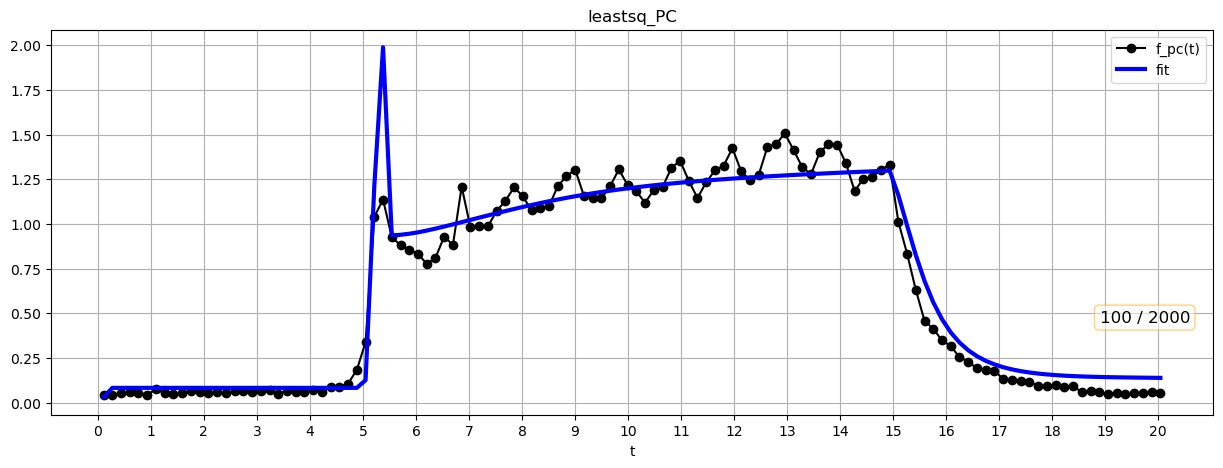


CPU times: total: 10min 7s
Wall time: 10min 8s


In [46]:
%%time
%matplotlib inline

result_leastsq = minimize(residual_ad, params, method='least_squares', args=(t_exp, init, data_pc_sen), nan_policy='propagate', max_nfev=100, ftol=1e-15, gtol=1e-15, xtol=1e-15)
print()


In [47]:
report_fit(result_leastsq)

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 100
    # data points      = 122
    # variables        = 5
    chi-square         = 1.65679176
    reduced chi-square = 0.01416061
    Akaike info crit   = -514.494834
    Bayesian info crit = -500.474729
##  Warning: uncertainties could not be estimated:
[[Variables]]
    w_0:        0.08281103 (fixed)
    w_1:        1.5197 (fixed)
    w_2:        1.06619 (fixed)
    w_3:        1.955607 (fixed)
    w_4:        0.631901 (fixed)
    w_5:        0.2072392 (fixed)
    w_6:        0.9263685 (fixed)
    w_7:        2.111694 (fixed)
    w_8:        1.510296 (fixed)
    w_9:        0.2501333 (fixed)
    w_10:       0.7837073 (fixed)
    w_11:       0.5941593 (fixed)
    w_12:       0.1499703 (fixed)
    w_13:       0.3239899 (fixed)
    w_14:       0.1911258 (fixed)
    w_15:       0.737623 (fixed)
    w_16:       1.146001 (fixed)
    w_17:       0.1758075 (fixed)
    w_18:       0.1580682 (fixed)
    tau_0:

In [48]:
a_leastsq = RMSE(result_leastsq.params, init, data_pc_sen, "f_e_d")
print(a_leastsq)

0.1169333614624254


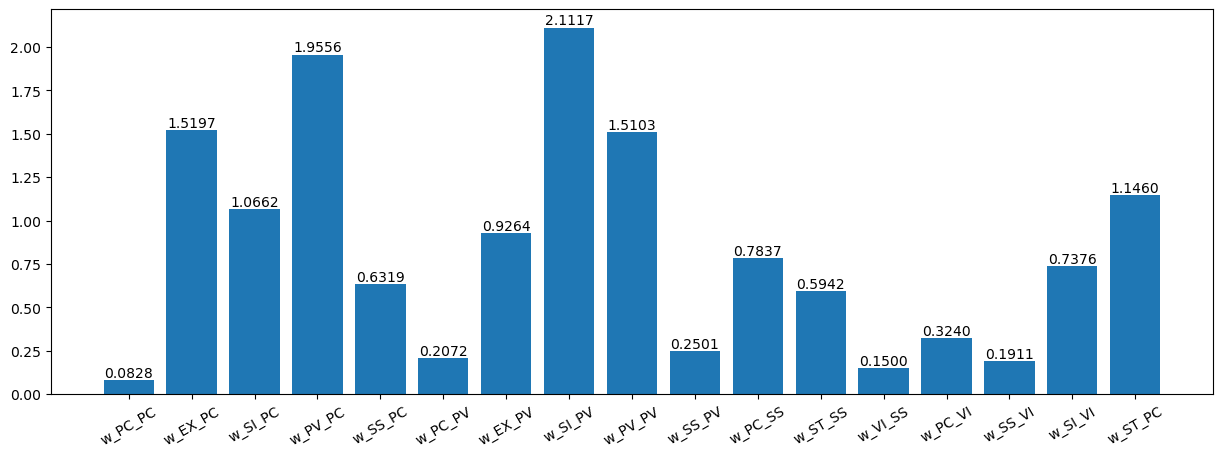

In [49]:
vals = []
for _, param in result_leastsq.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

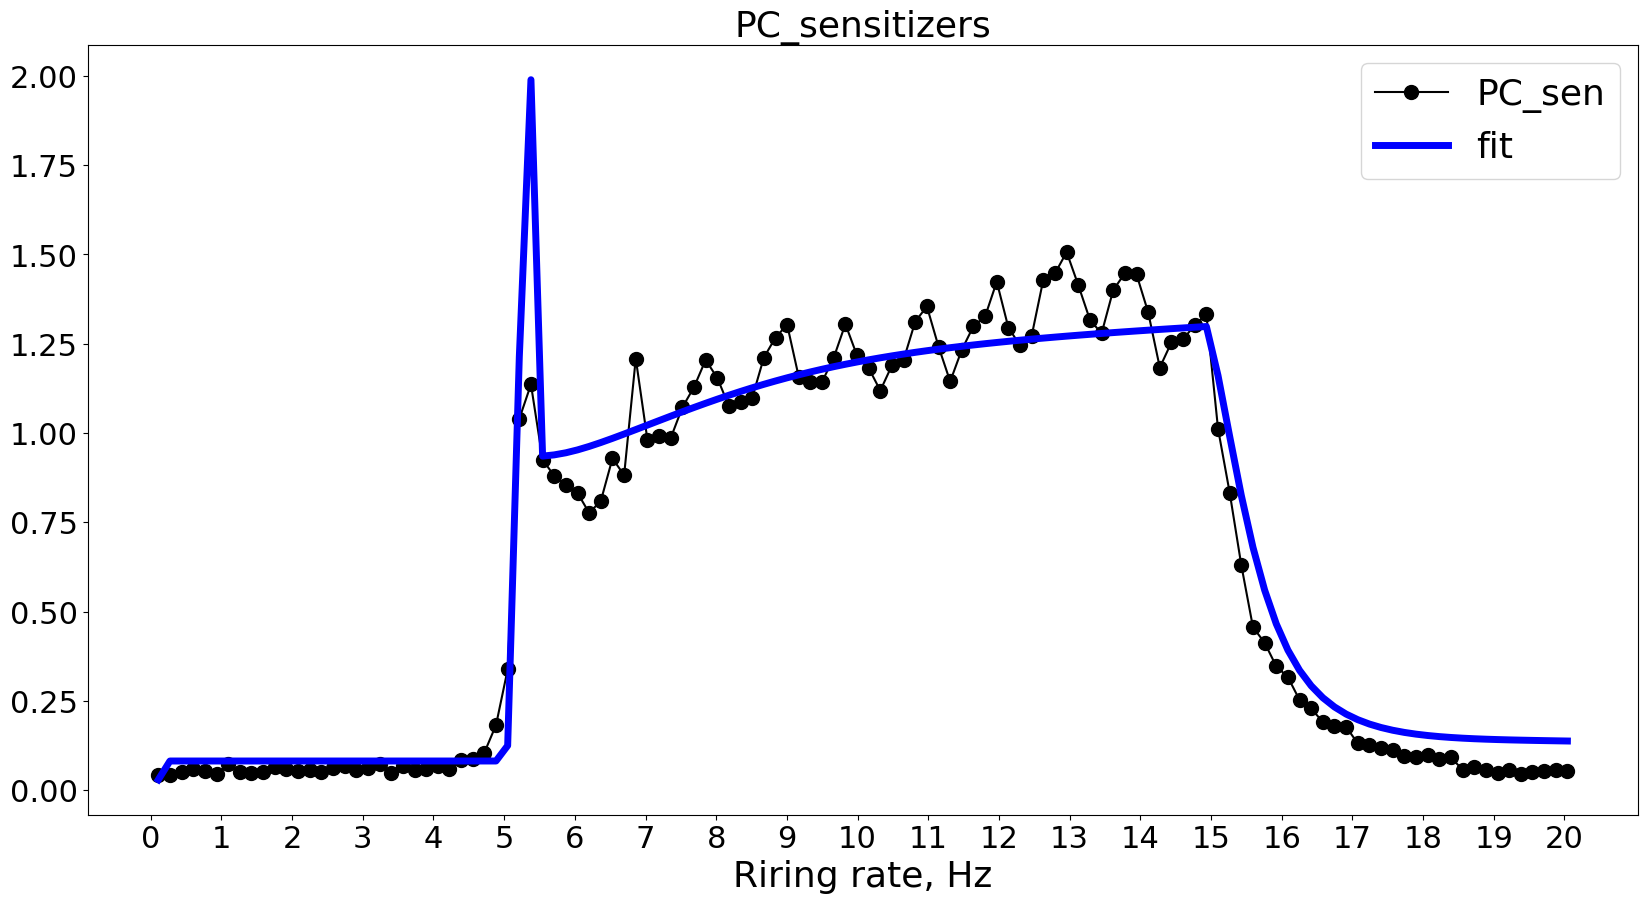

In [50]:
sim_leastsq = simulate_step(t_exp, init, params)
fit_leastsq = simulate_step(t_exp, init, result_leastsq.params)
# step = []

# for i in t_exp:
#     step.append(Step(i))
    
# curve = np.array(step) * result_leastsq.params['w_1'].value
    
plt.figure(figsize=(20,10))
plt.plot(t_exp, data_pc_sen, color='black', marker='o', label='PC_sen', markersize = 10)
plt.plot(t_exp, fit_leastsq['f_e_d'].values, color='blue', label='fit', linewidth=5)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('PC_sensitizers', fontsize=26)
plt.legend(loc='best', fontsize=26)
plt.xlabel('time, t', fontsize=26)
plt.xlabel('Riring rate, Hz', fontsize=26)
#plt.ylim(0, 1.2)
plt.xticks(np.arange(0,21,1), size =22)
plt.yticks(size =22)
#plt.grid()
plt.show()

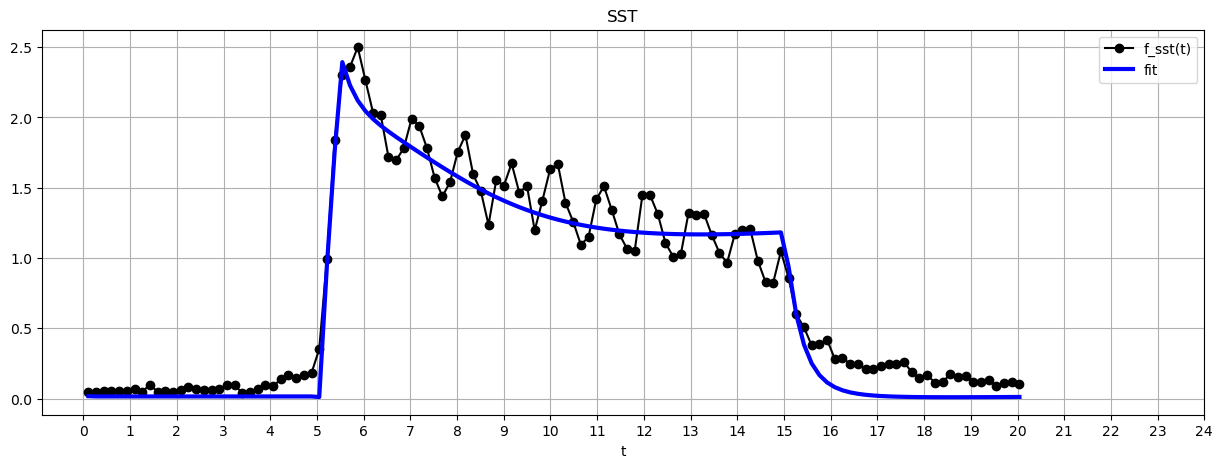

In [51]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_leastsq['f_sst'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

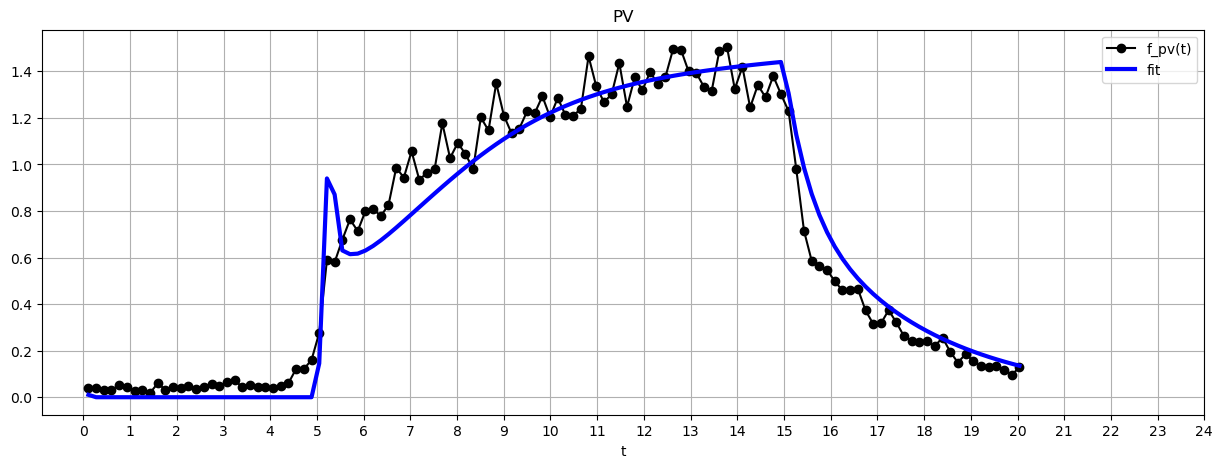

In [52]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_leastsq['f_pv'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

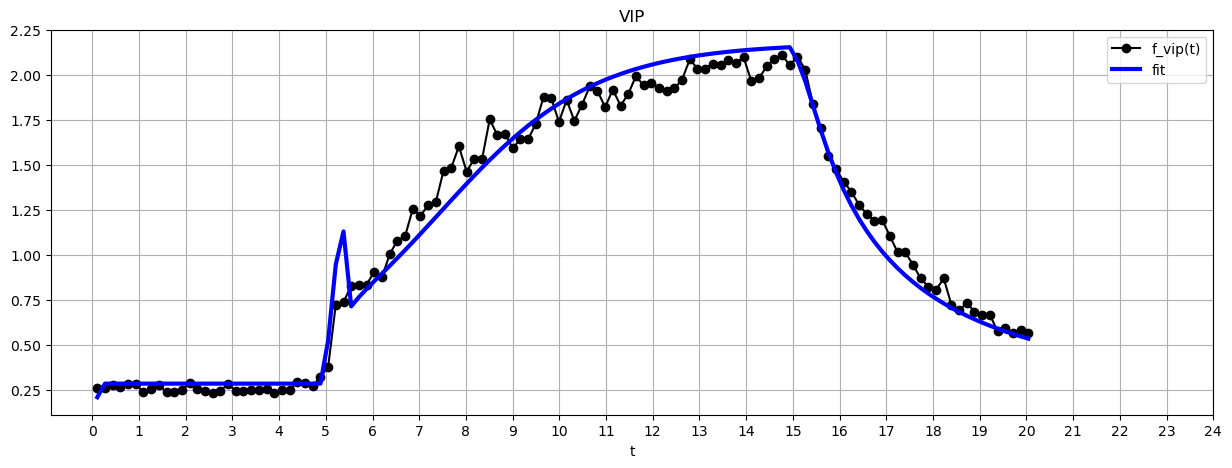

In [53]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_leastsq['f_vip'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

In [54]:
model_opto = simulate_step(t_exp, init, result_leastsq.params)

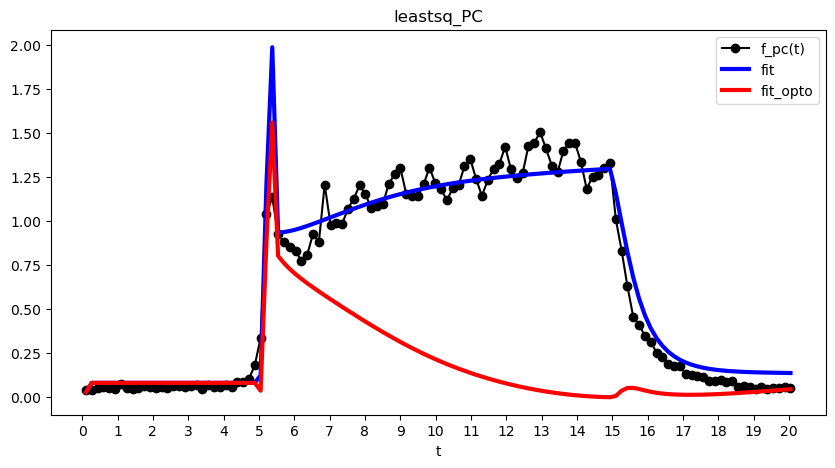

In [55]:
plt.figure(figsize=(10,5))
plt.plot(t_exp, data_pc_sen, color='black', marker='o', label='f_pc(t)')
#plt.plot(t_exp, data_pc_sen_pv_arch, color='gray', marker='o', label='f_pc_opto_pv_arch')
#plt.plot(t_exp, data_pc_sen_pv_chr, color='green', marker='o', label='f_pc_opto_pv_chr')
#plt.plot(t_exp, data_pc_sen_sst_arch, color='gray', marker='o', label='f_pc_opto_sst_arch')
#plt.plot(t_exp, data_pc_sen_sst_chr, color='green', marker='o', label='f_pc_opto_sst_chr')
plt.plot(t_exp, model_opto['f_e_d'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_e_do'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.xlim(3,7)
#plt.grid()
plt.show()

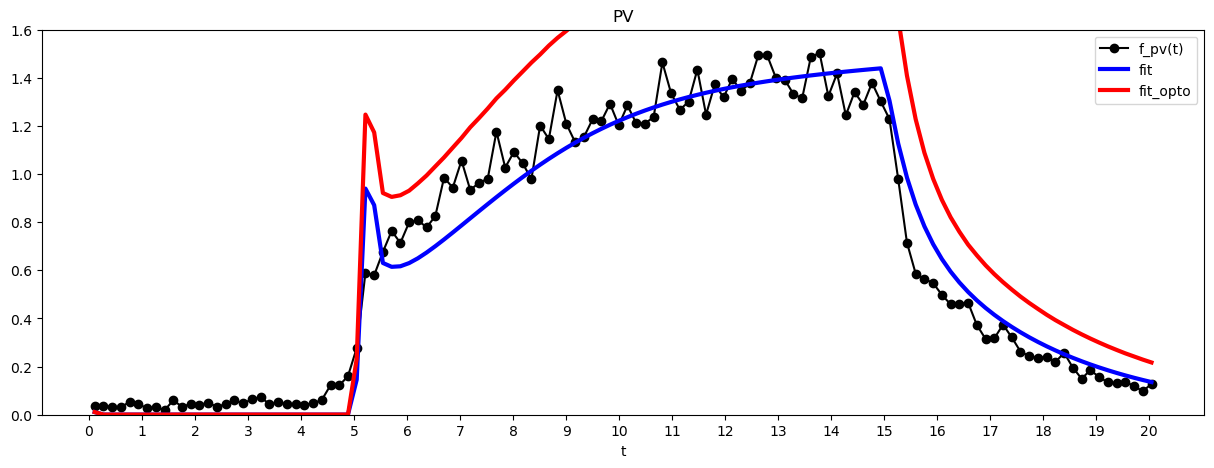

In [56]:
plt.figure(figsize=(15,5))
fast = []
slow = []
for i in t_exp:
    fast.append(0.33181904 * expon(i, ampl = 2.21679020, base = 2.8, decay = 2.86514393, delay = 0.02399650))
    slow.append(0.62204067 * Sigm(i, rate = 1.46386253, delay = 2.37599864))

plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, data_pc_all, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, fast, color='green', label='fit', linewidth=3)
#plt.plot(t_exp, slow, color='orange', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_pv'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_pv_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

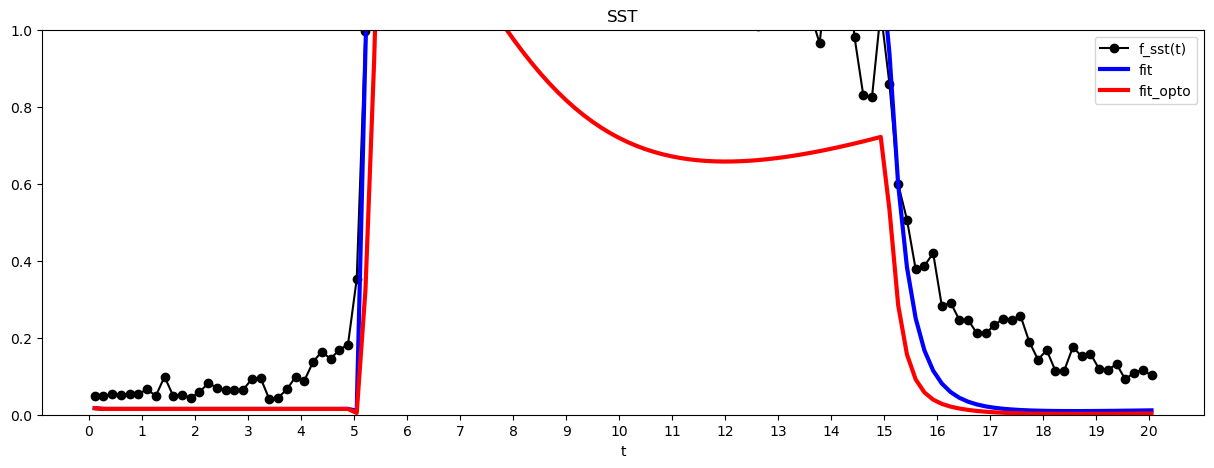

In [57]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, model_opto['f_sst'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_sst_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.0)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

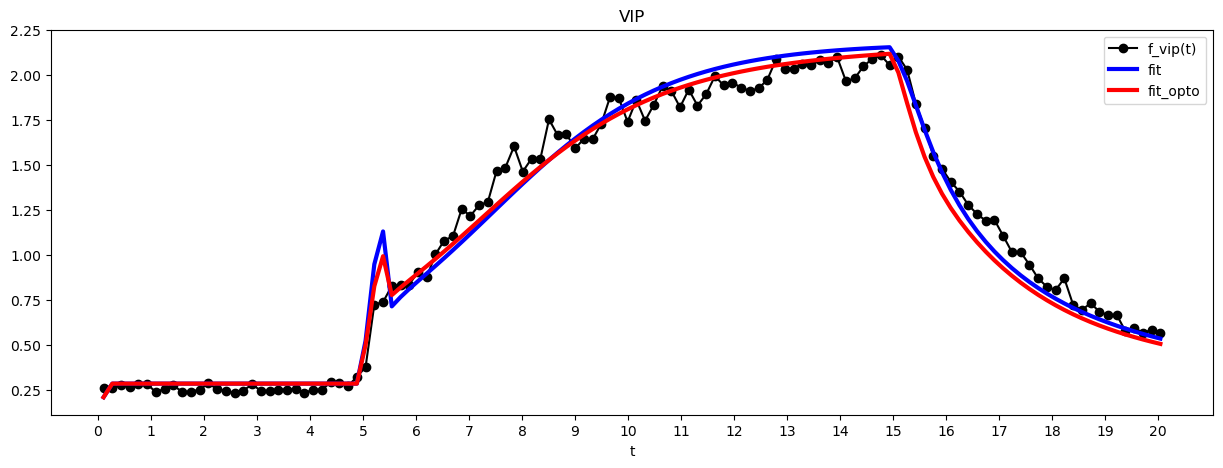

In [58]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, model_opto['f_vip'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_vip_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 2.2)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [59]:
heat_old = pd.DataFrame()
heat_old[''] = ['PC', 'SST', 'PV', 'VIP_P']

heat_old['PC'] = [0.08281103,
                  0.78370724,
                  0.20723919,
                  0.32398988]

heat_old['SST'] = [0.63190096,
                  None,
                  0.25013329,
                  0.19112577]

heat_old['PV'] = [1.95560664,
                   None,
                   1.51029559,
                   None]

heat_old['VIP_P'] = [None,
                   0.14997032,
                   None,
                   None]

heat_old['FF'] = [1.51969985,
                   None,
                   0.92636845,
                   None]

heat_old['SM'] = [1.06618999,
                   None,
                   2.11169434,
                   0.73762300]

heat_old['FB'] = [1.14600083,
                   0.59415933,
                   0.17580747,
                   0.15806817]

heat_old.set_index('', inplace = True)

In [60]:
heat_old = heat_old.map(lambda x: np.nan if x is None else x)

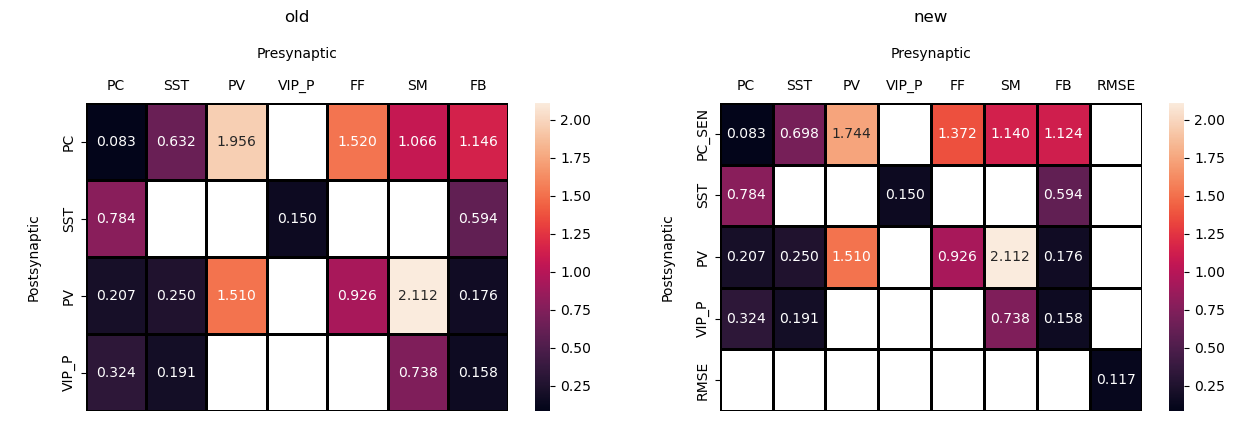

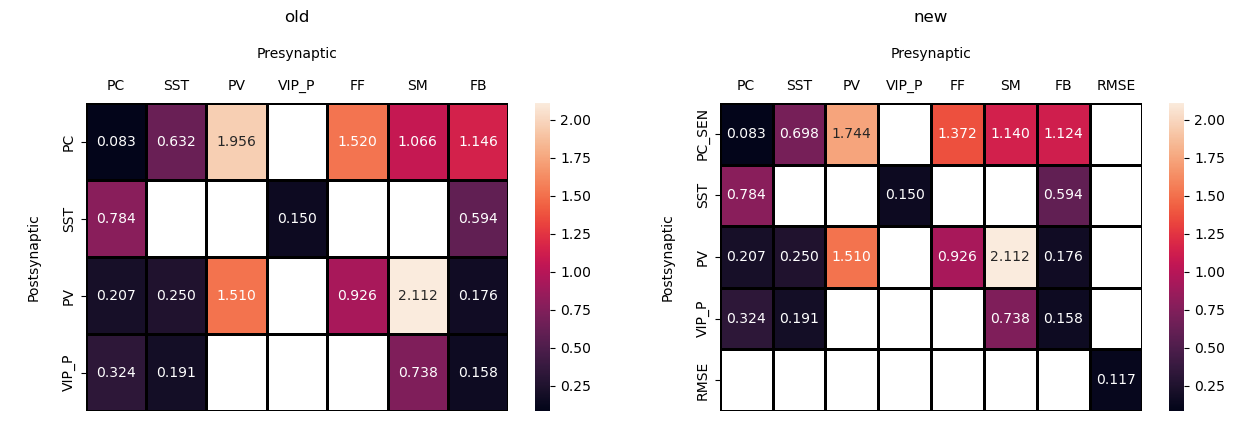

In [61]:
heat_new = pd.DataFrame()
heat_new[''] = ['PC_SEN', 'SST', 'PV', 'VIP_P', 'RMSE']

heat_new['PC'] = [result_leastsq.params["w_d_0"].value / scale,
                  0.78370724,
                  0.20723919,
                  0.32398988,
                  None]

heat_new['SST'] = [result_leastsq.params["w_d_5"].value / scale,
                  None,
                  0.25013329,
                  0.19112577,
                  None]

heat_new['PV'] = [result_leastsq.params["w_d_4"].value / scale,
                   None,
                   1.51029559,
                   None,
                   None]

heat_new['VIP_P'] = [None,
                   0.14997032,
                   None,
                   None,
                   None]


heat_new['FF'] = [result_leastsq.params["w_d_1"].value / scale,
                   None,
                   0.92636845,
                   None,
                   None]

heat_new['SM'] = [result_leastsq.params["w_d_2"].value / scale,
                   None,
                   2.11169434,
                   0.73762300,
                   None]

heat_new['FB'] = [result_leastsq.params["w_d_3"].value / scale,
                   0.59415933,
                   0.17580747,
                   0.15806817,
                   None]

heat_new['RMSE'] = [None,
                   None,
                   None,
                   None,
                   a_leastsq]

heat_new.set_index('', inplace = True)

heat_new = heat_new.map(lambda x: np.nan if x is None else x)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.heatmap(heat_old, ax=ax[0], annot = True, linewidth = 1, linecolor = 'black', fmt=".3f")
sns.heatmap(heat_new, ax=ax[1], annot = True, linewidth = 1, linecolor = 'black', fmt=".3f")
ax[0].tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax[0].set(xlabel="\nPresynaptic\n", ylabel="\nPostsynaptic\n")
ax[0].title.set_text("old")
ax[0].xaxis.set_label_position("top")
ax[1].tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax[1].set(xlabel="\nPresynaptic\n", ylabel="\nPostsynaptic\n")
ax[1].title.set_text("new")
ax[1].xaxis.set_label_position("top")
display.display(fig)

## least_squares

In [62]:
count = 0

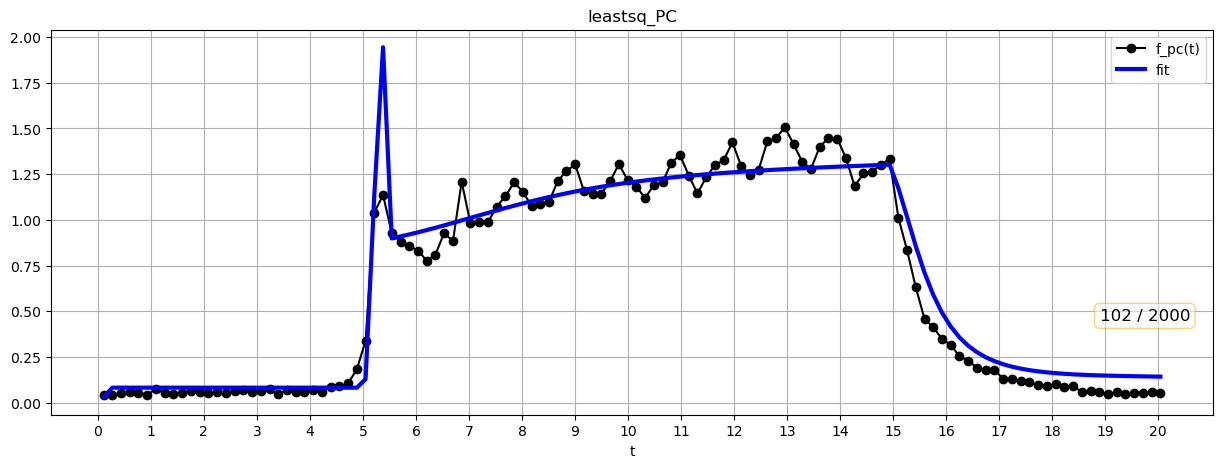


CPU times: total: 10min 25s
Wall time: 10min 27s


In [63]:
%%time
%matplotlib inline

result_leastsqs = minimize(residual_ad, params, method='leastsq', args=(t_exp, init, data_pc_sen), nan_policy='propagate', max_nfev=100, ftol=1e-15, gtol=1e-15, xtol=1e-15)
print()


In [64]:
report_fit(result_leastsqs)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = 122
    # variables        = 5
    chi-square         = 1.61522929
    reduced chi-square = 0.01380538
    Akaike info crit   = -517.594383
    Bayesian info crit = -503.574278
##  Warning: uncertainties could not be estimated:
[[Variables]]
    w_0:        0.08281103 (fixed)
    w_1:        1.5197 (fixed)
    w_2:        1.06619 (fixed)
    w_3:        1.955607 (fixed)
    w_4:        0.631901 (fixed)
    w_5:        0.2072392 (fixed)
    w_6:        0.9263685 (fixed)
    w_7:        2.111694 (fixed)
    w_8:        1.510296 (fixed)
    w_9:        0.2501333 (fixed)
    w_10:       0.7837073 (fixed)
    w_11:       0.5941593 (fixed)
    w_12:       0.1499703 (fixed)
    w_13:       0.3239899 (fixed)
    w_14:       0.1911258 (fixed)
    w_15:       0.737623 (fixed)
    w_16:       1.146001 (fixed)
    w_17:       0.1758075 (fixed)
    w_18:       0.1580682 (fixed)
    tau_0:      

In [65]:
a_leastsqs = RMSE(result_leastsqs.params, init, data_pc_sen, "f_e_d")
print(a_leastsqs)

0.11546841191517232


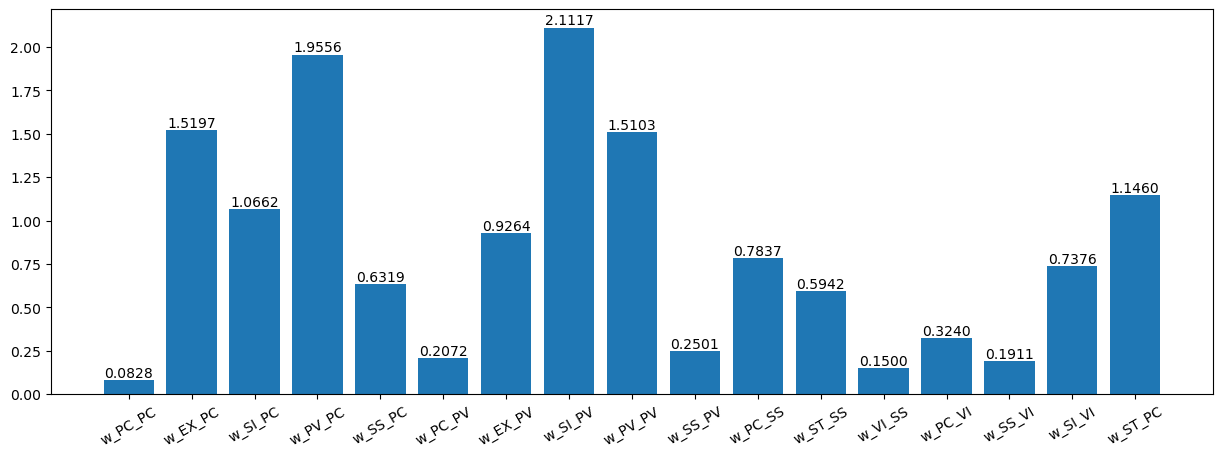

In [66]:
vals = []
for _, param in result_leastsqs.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

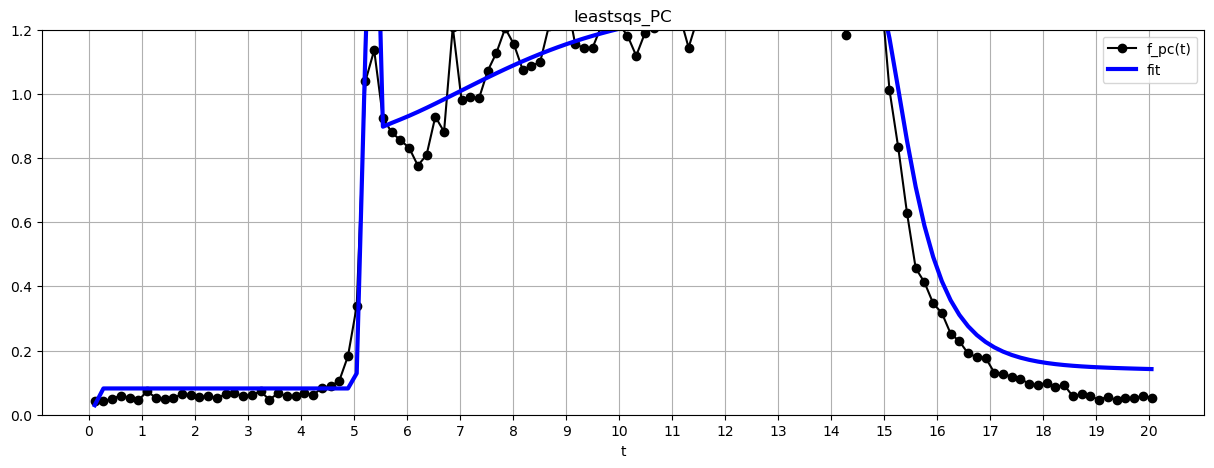

In [67]:
sim_leastsqs = simulate_step(t_exp, init, params)
fit_leastsqs = simulate_step(t_exp, init, result_leastsqs.params)
step = []

for i in t_exp:
    step.append(Step(i))
    
curve = np.array(step) * result_leastsqs.params['w_1'].value
    
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pc_sen, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_leastsqs['f_e_d'].values, color='blue', label='fit', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('leastsqs_PC')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.2)
plt.xticks(np.arange(0,21,1))
plt.grid()
plt.show()

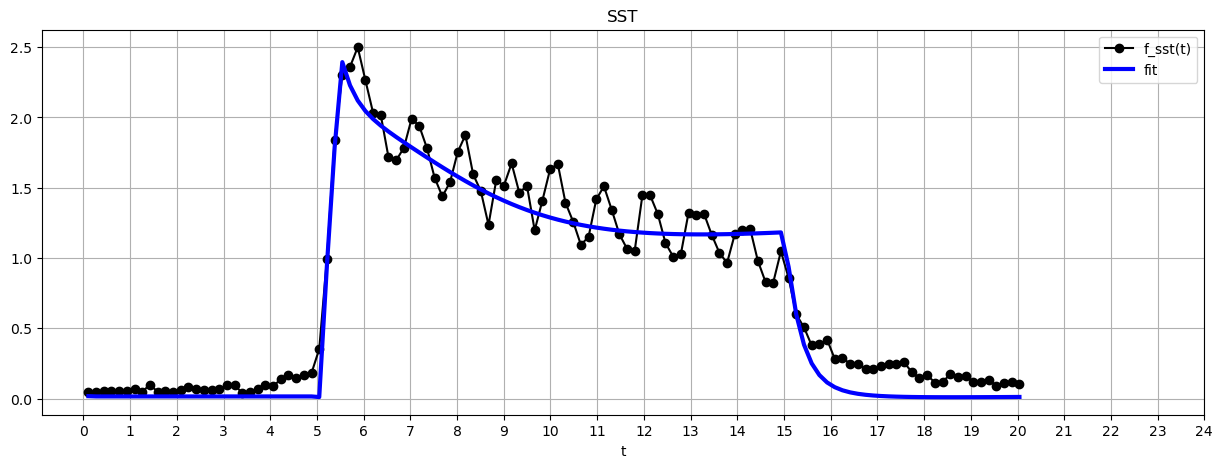

In [68]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_leastsqs['f_sst'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

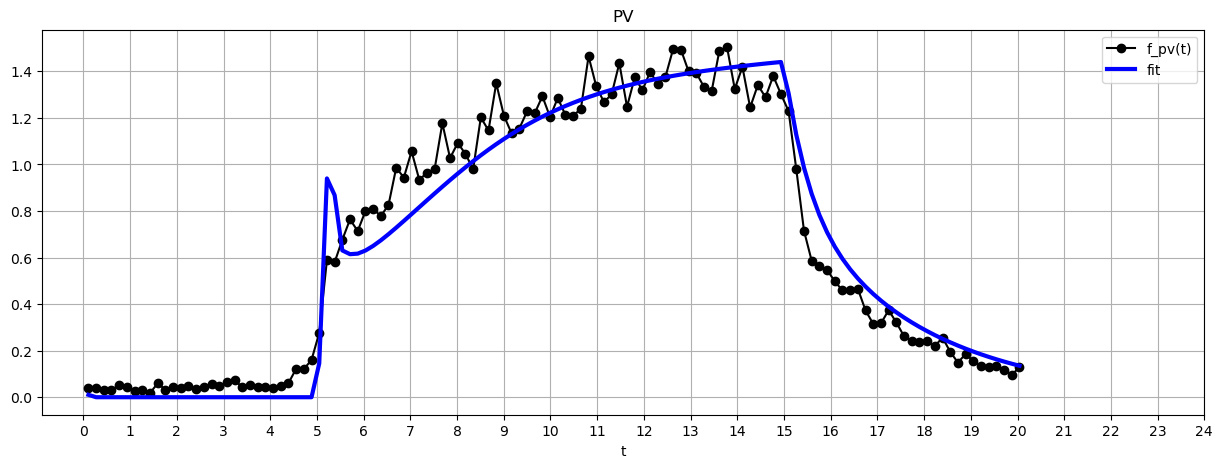

In [69]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_leastsqs['f_pv'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

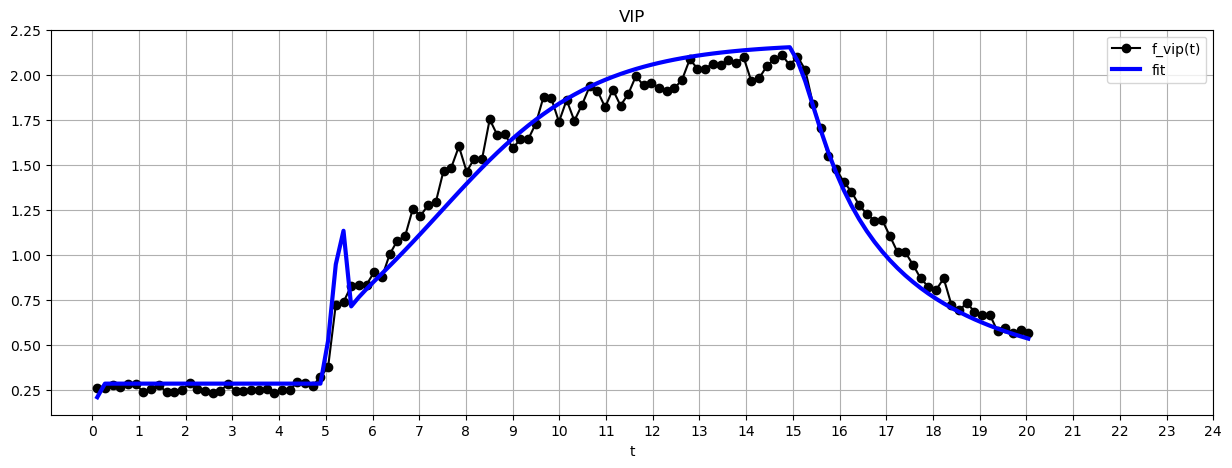

In [70]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_leastsqs['f_vip'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

In [71]:
model_opto = simulate_step(t_exp, init, result_leastsqs.params)

In [72]:
model_opto[['t', 'f_e_do']].to_csv('trace_s1_hab_Loco_SEN_27_03_2025.csv', index=False)

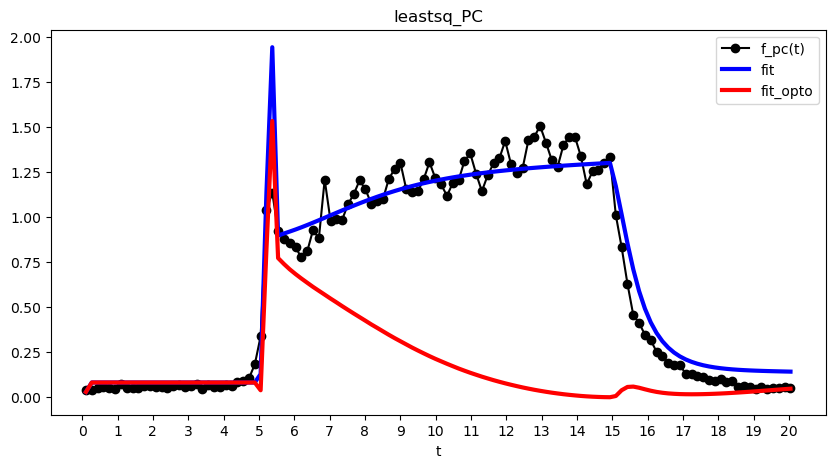

In [73]:
plt.figure(figsize=(10,5))
plt.plot(t_exp, data_pc_sen, color='black', marker='o', label='f_pc(t)')
#plt.plot(t_exp, data_pc_sen_pv_arch, color='gray', marker='o', label='f_pc_opto_pv_arch')
#plt.plot(t_exp, data_pc_sen_pv_chr, color='green', marker='o', label='f_pc_opto_pv_chr')
#plt.plot(t_exp, data_pc_sen_sst_arch, color='gray', marker='o', label='f_pc_opto_sst_arch')
#plt.plot(t_exp, data_pc_sen_sst_chr, color='green', marker='o', label='f_pc_opto_sst_chr')
plt.plot(t_exp, model_opto['f_e_d'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_e_do'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.xlim(3,7)
#plt.grid()
plt.show()

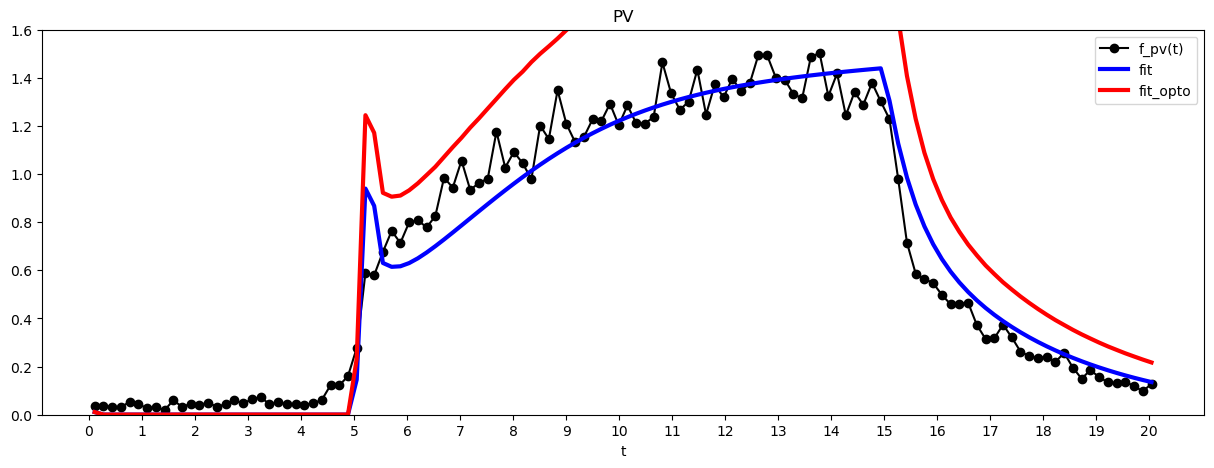

In [74]:
plt.figure(figsize=(15,5))
fast = []
slow = []
for i in t_exp:
    fast.append(0.33181904 * expon(i, ampl = 2.21679020, base = 2.8, decay = 2.86514393, delay = 0.02399650))
    slow.append(0.62204067 * Sigm(i, rate = 1.46386253, delay = 2.37599864))

plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, data_pc_all, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, fast, color='green', label='fit', linewidth=3)
#plt.plot(t_exp, slow, color='orange', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_pv'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_pv_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

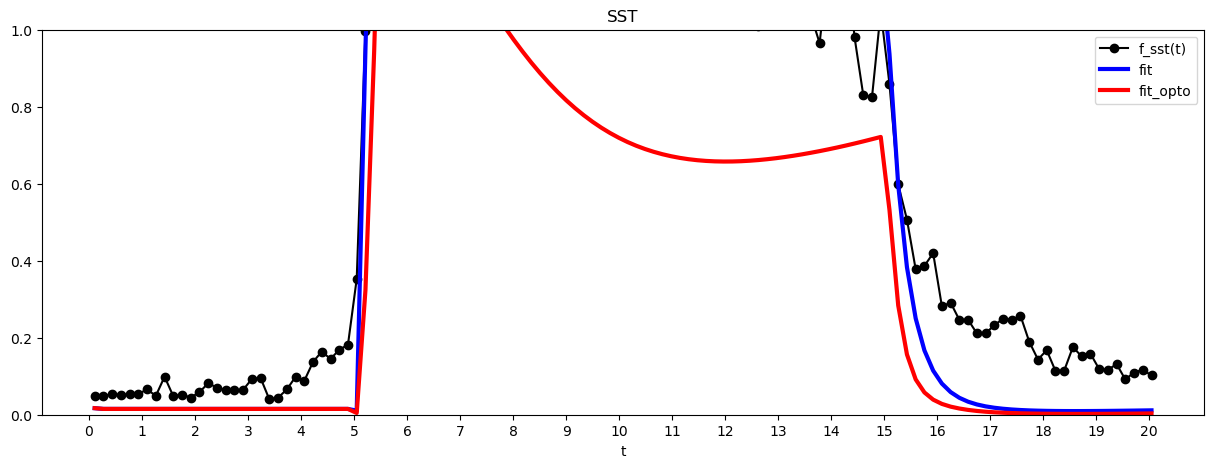

In [75]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, model_opto['f_sst'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_sst_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.0)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

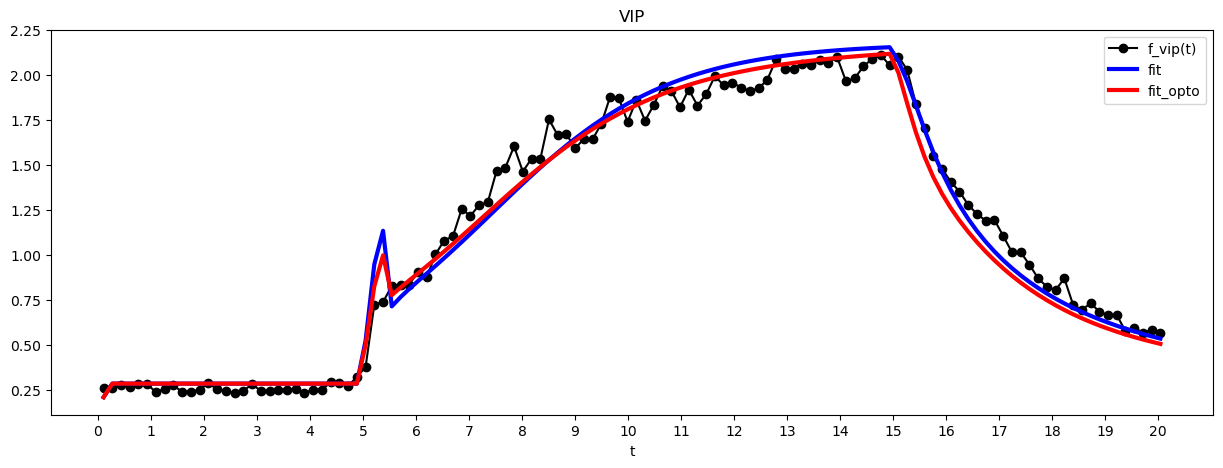

In [76]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, model_opto['f_vip'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_vip_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 2.2)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

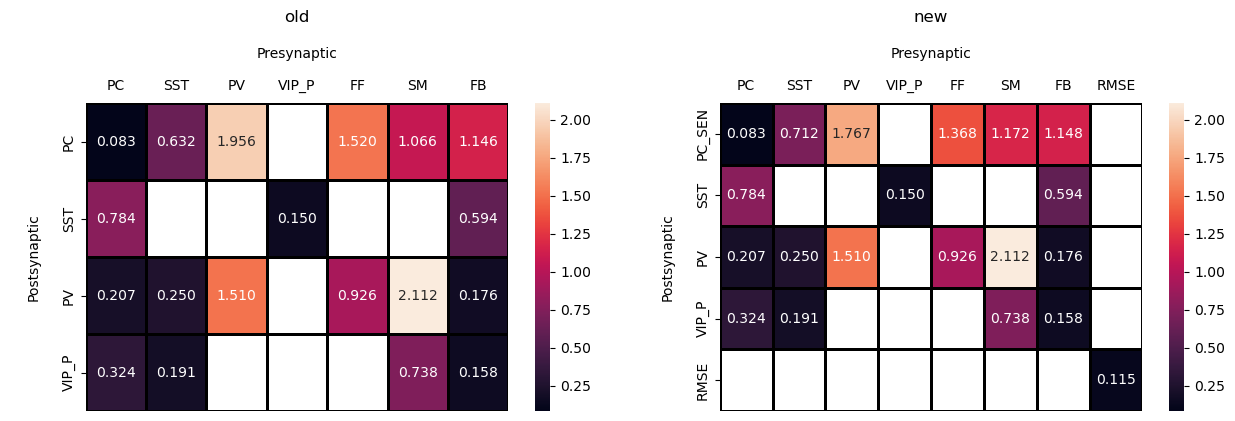

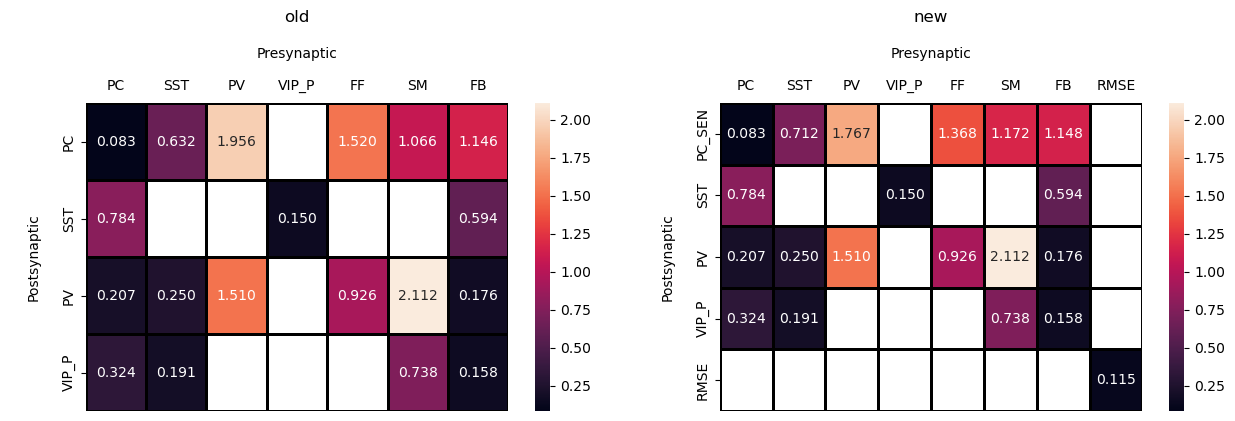

In [77]:
heat_new = pd.DataFrame()
heat_new[''] = ['PC_SEN', 'SST', 'PV', 'VIP_P', 'RMSE']

heat_new['PC'] = [result_leastsqs.params["w_d_0"].value / scale,
                  0.78370724,
                  0.20723919,
                  0.32398988,
                  None]

heat_new['SST'] = [result_leastsqs.params["w_d_5"].value / scale,
                  None,
                  0.25013329,
                  0.19112577,
                  None]

heat_new['PV'] = [result_leastsqs.params["w_d_4"].value / scale,
                   None,
                   1.51029559,
                   None,
                   None]

heat_new['VIP_P'] = [None,
                   0.14997032,
                   None,
                   None,
                   None]


heat_new['FF'] = [result_leastsqs.params["w_d_1"].value / scale,
                   None,
                   0.92636845,
                   None,
                   None]

heat_new['SM'] = [result_leastsqs.params["w_d_2"].value / scale,
                   None,
                   2.11169434,
                   0.73762300,
                   None]

heat_new['FB'] = [result_leastsqs.params["w_d_3"].value / scale,
                   0.59415933,
                   0.17580747,
                   0.15806817,
                   None]

heat_new['RMSE'] = [None,
                   None,
                   None,
                   None,
                   a_leastsqs]

heat_new.set_index('', inplace = True)

heat_new = heat_new.map(lambda x: np.nan if x is None else x)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.heatmap(heat_old, ax=ax[0], annot = True, linewidth = 1, linecolor = 'black', fmt=".3f")
sns.heatmap(heat_new, ax=ax[1], annot = True, linewidth = 1, linecolor = 'black', fmt=".3f")
ax[0].tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax[0].set(xlabel="\nPresynaptic\n", ylabel="\nPostsynaptic\n")
ax[0].title.set_text("old")
ax[0].xaxis.set_label_position("top")
ax[1].tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax[1].set(xlabel="\nPresynaptic\n", ylabel="\nPostsynaptic\n")
ax[1].title.set_text("new")
ax[1].xaxis.set_label_position("top")
display.display(fig)

In [78]:
heat_new.to_csv("heatmap_s1_hab_Loco_SEN_27_03_2025.csv")

## nelder

In [79]:
count = 0

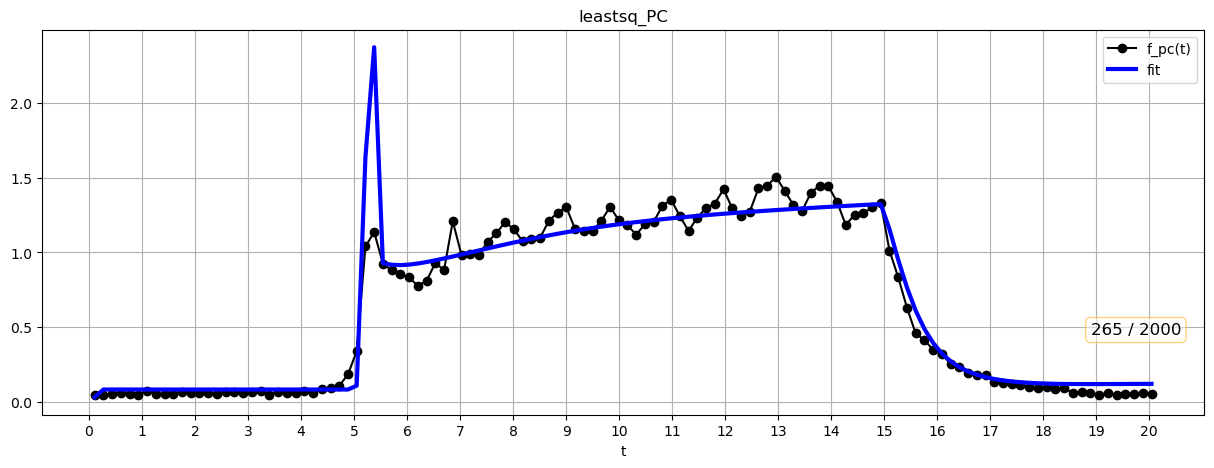


CPU times: total: 23min 15s
Wall time: 23min 21s


In [80]:
%%time

%matplotlib inline

result_nelder = minimize(residual_ad, params, method='nelder', args=(t_exp, init, data_pc_sen), nan_policy='propagate', options = {'adaptive' : True}, max_nfev = 1500)
print()


In [81]:
report_fit(result_nelder)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 214
    # data points      = 122
    # variables        = 5
    chi-square         = 2.55718694
    reduced chi-square = 0.02185630
    Akaike info crit   = -461.543815
    Bayesian info crit = -447.523710
##  Warning: uncertainties could not be estimated:
[[Variables]]
    w_0:        0.08281103 (fixed)
    w_1:        1.5197 (fixed)
    w_2:        1.06619 (fixed)
    w_3:        1.955607 (fixed)
    w_4:        0.631901 (fixed)
    w_5:        0.2072392 (fixed)
    w_6:        0.9263685 (fixed)
    w_7:        2.111694 (fixed)
    w_8:        1.510296 (fixed)
    w_9:        0.2501333 (fixed)
    w_10:       0.7837073 (fixed)
    w_11:       0.5941593 (fixed)
    w_12:       0.1499703 (fixed)
    w_13:       0.3239899 (fixed)
    w_14:       0.1911258 (fixed)
    w_15:       0.737623 (fixed)
    w_16:       1.146001 (fixed)
    w_17:       0.1758075 (fixed)
    w_18:       0.1580682 (fixed)
    tau_0:  

In [82]:
a_nelder = RMSE(result_nelder.params, init, data_pc_sen, "f_e_d")
print(a_nelder)

0.14510288720975772


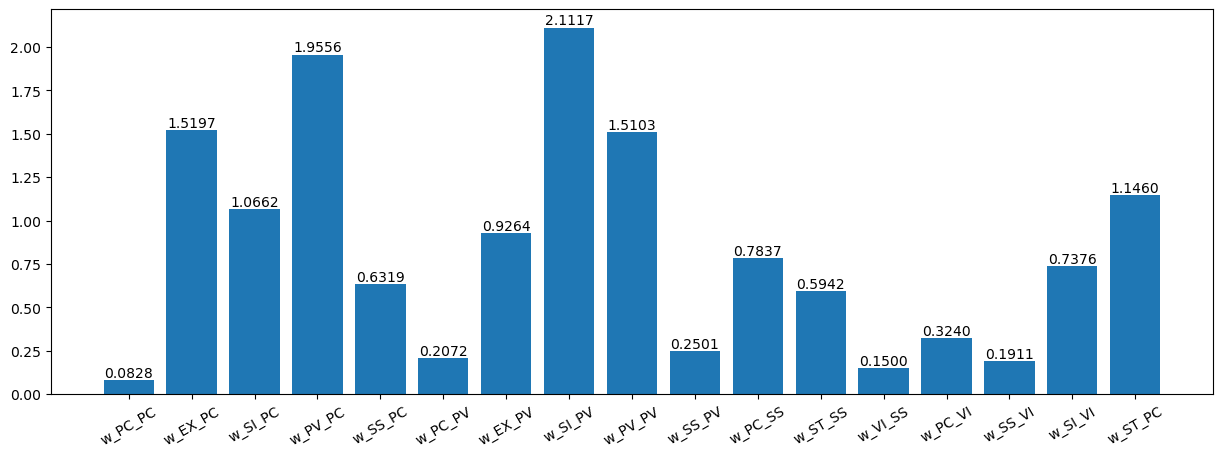

In [83]:
vals = []
for _, param in result_nelder.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

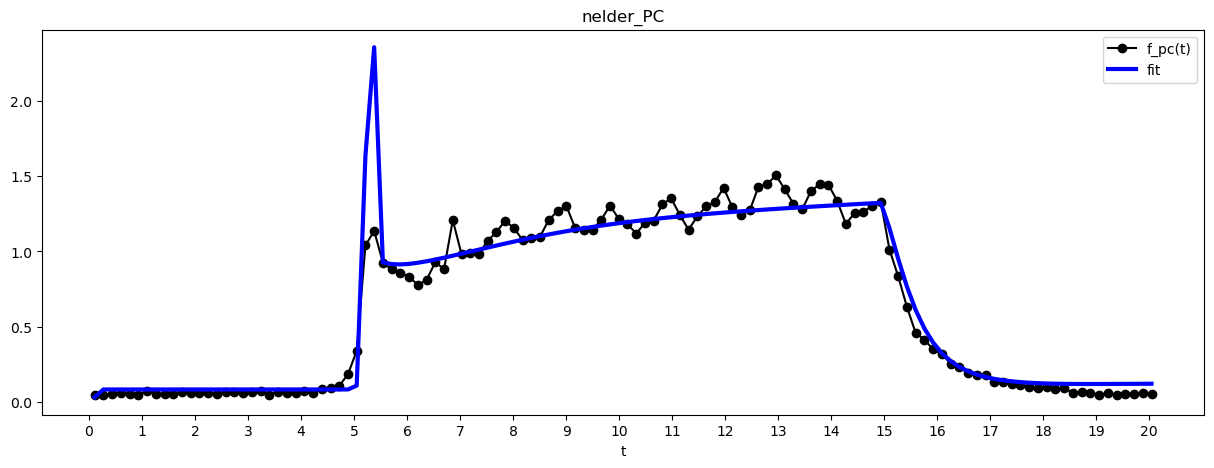

In [84]:
sim_nelder = simulate_step(t_exp, init, params)
fit_nelder = simulate_step(t_exp, init, result_nelder.params)
step_pv = []
#step_sst = []
# step = []

# for i in t_exp:
#     #step_sst.append(f_s(i, data_sst_exc))
#     step.append(Step(i, amp = 0.5, base = 0.0))
    
# curve =np.array(step) * result_nelder.params['w_2'].value

plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pc_sen, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_nelder['f_e_d'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_nelder['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('nelder_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 5)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

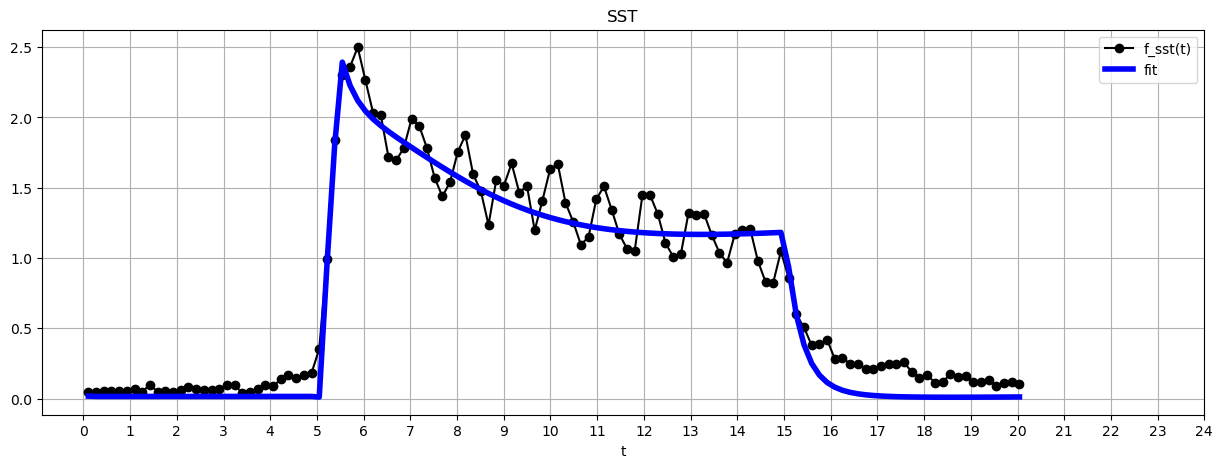

In [85]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_nelder['f_sst'].values, color='blue', label='fit', linewidth=4)
#plt.plot(t_exp, sim_nelder['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.ylim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

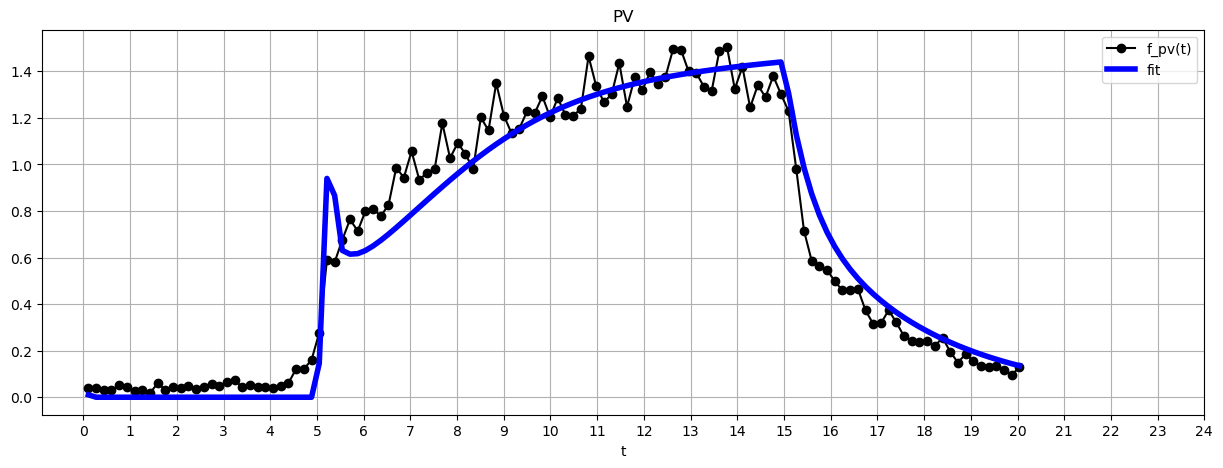

In [86]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_nelder['f_pv'].values, color='blue', label='fit', linewidth=4)
#plt.plot(t_exp, sim_nelder['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

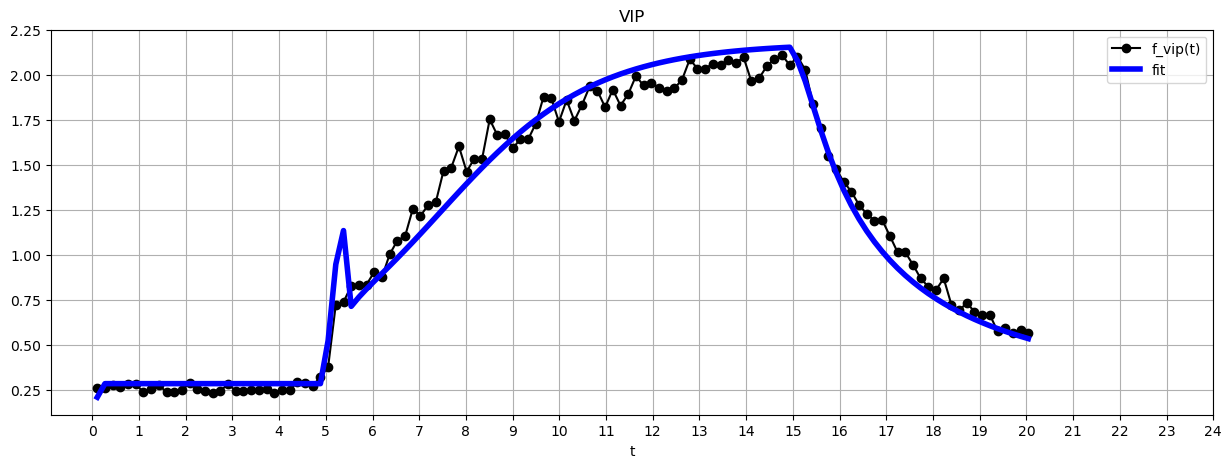

In [87]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_nelder['f_vip'].values, color='blue', label='fit', linewidth=4)
#plt.plot(t_exp, sim_nelder['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

In [88]:
model_opto = simulate_step(t_exp, init, result_nelder.params)

In [89]:
model_opto[['t', 'f_e_do']].to_csv('trace_C_s1_hab_Loco_SEN_07_04_2025.csv', index=False)

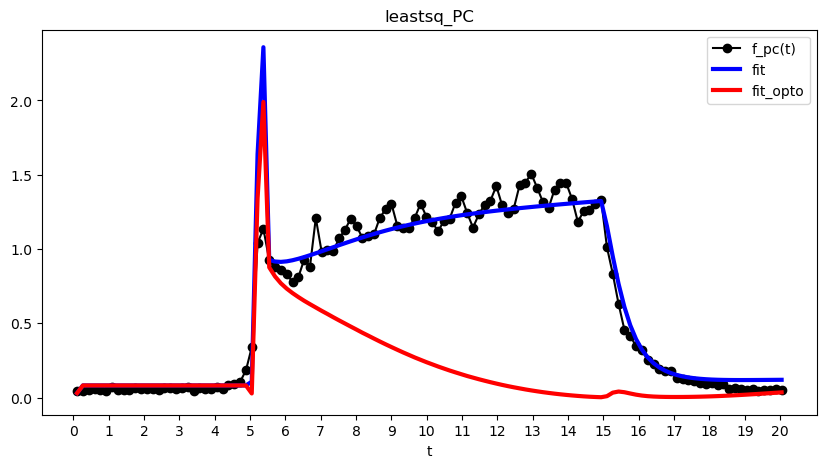

In [90]:
plt.figure(figsize=(10,5))
plt.plot(t_exp, data_pc_sen, color='black', marker='o', label='f_pc(t)')
#plt.plot(t_exp, data_pc_sen_pv_arch, color='gray', marker='o', label='f_pc_opto_pv_arch')
#plt.plot(t_exp, data_pc_sen_pv_chr, color='green', marker='o', label='f_pc_opto_pv_chr')
#plt.plot(t_exp, data_pc_sen_sst_arch, color='gray', marker='o', label='f_pc_opto_sst_arch')
#plt.plot(t_exp, data_pc_sen_sst_chr, color='green', marker='o', label='f_pc_opto_sst_chr')
plt.plot(t_exp, model_opto['f_e_d'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_e_do'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.xlim(3,7)
#plt.grid()
plt.show()

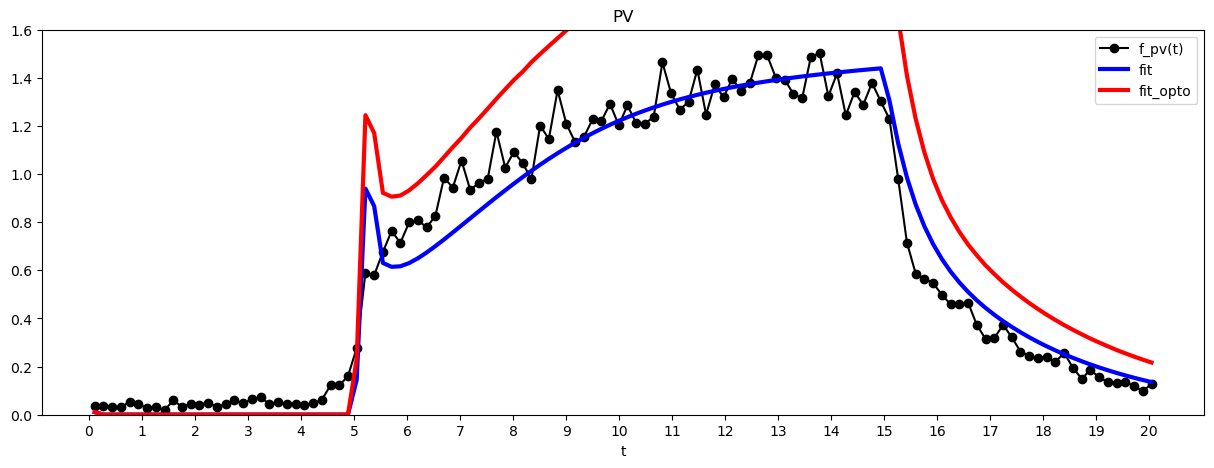

In [91]:
plt.figure(figsize=(15,5))
fast = []
slow = []
for i in t_exp:
    fast.append(0.33181904 * expon(i, ampl = 2.21679020, base = 2.8, decay = 2.86514393, delay = 0.02399650))
    slow.append(0.62204067 * Sigm(i, rate = 1.46386253, delay = 2.37599864))

plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, data_pc_all, color='black', marker='o', label='f_pv(t)')
#plt.plot(t_exp, fast, color='green', label='fit', linewidth=3)
#plt.plot(t_exp, slow, color='orange', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_pv'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_pv_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

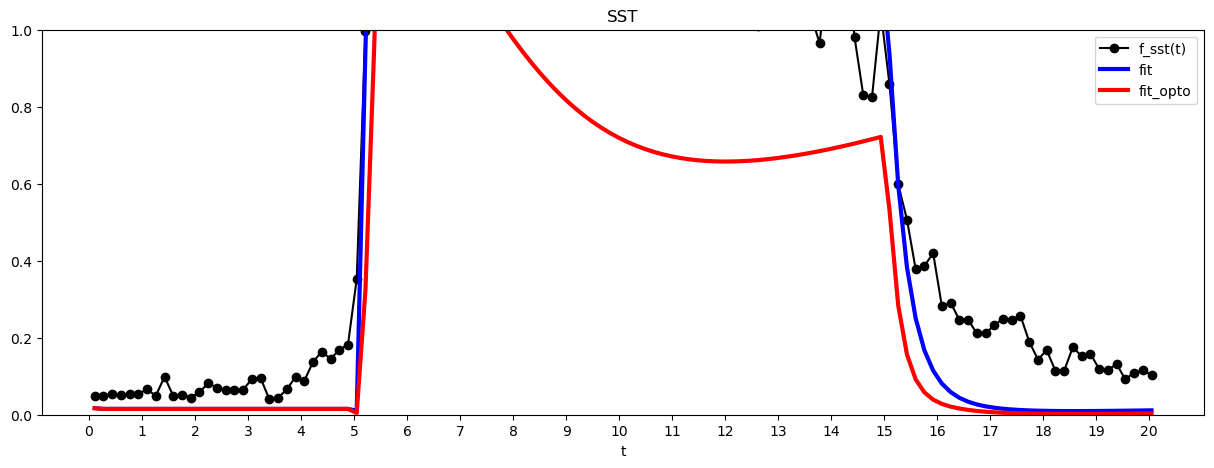

In [92]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, model_opto['f_sst'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_sst_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.0)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

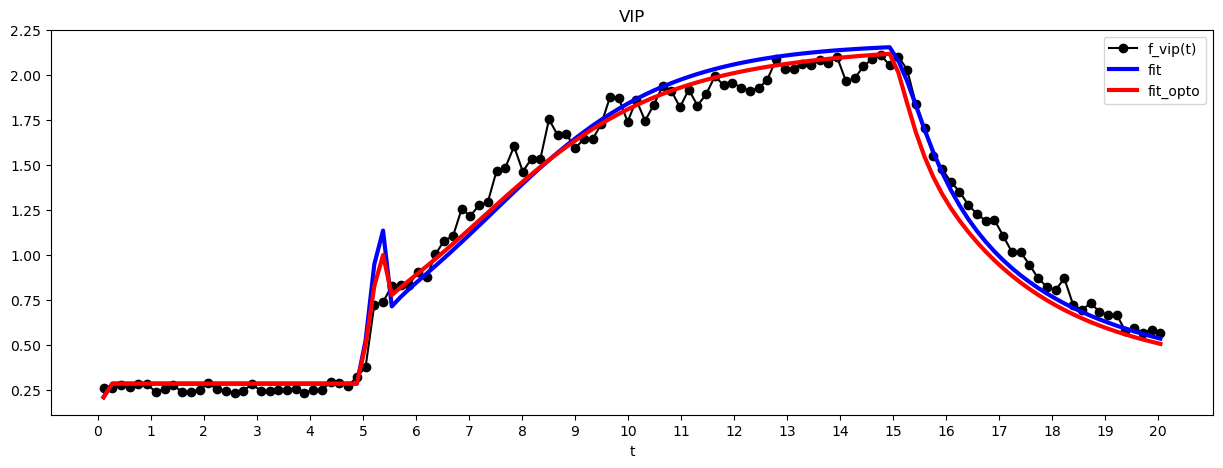

In [93]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, model_opto['f_vip'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_vip_o'].values, color='red', label='fit_opto', linewidth=3)
# plt.plot(t_exp, sim_leastsq['f_e'].values, color='red', label='init_fit')
#plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 2.2)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

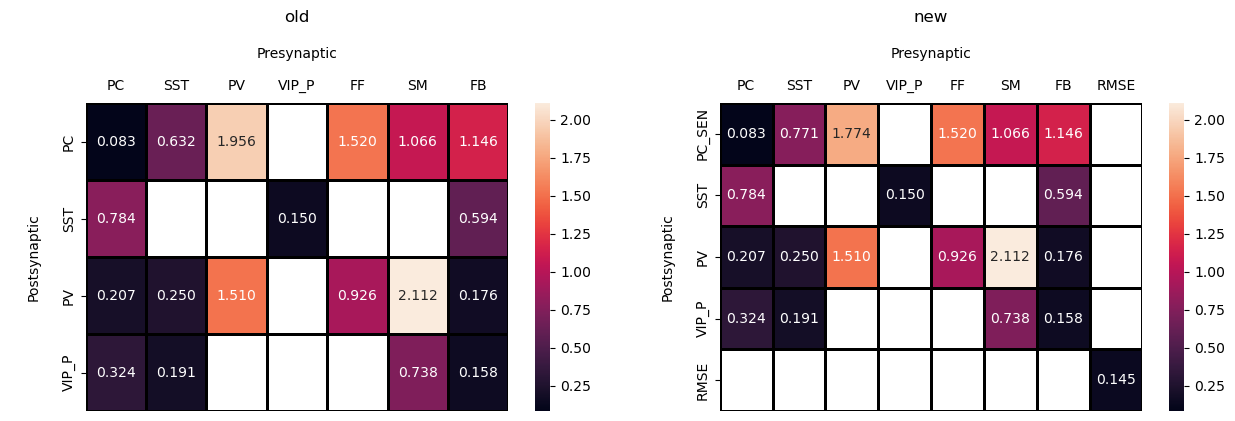

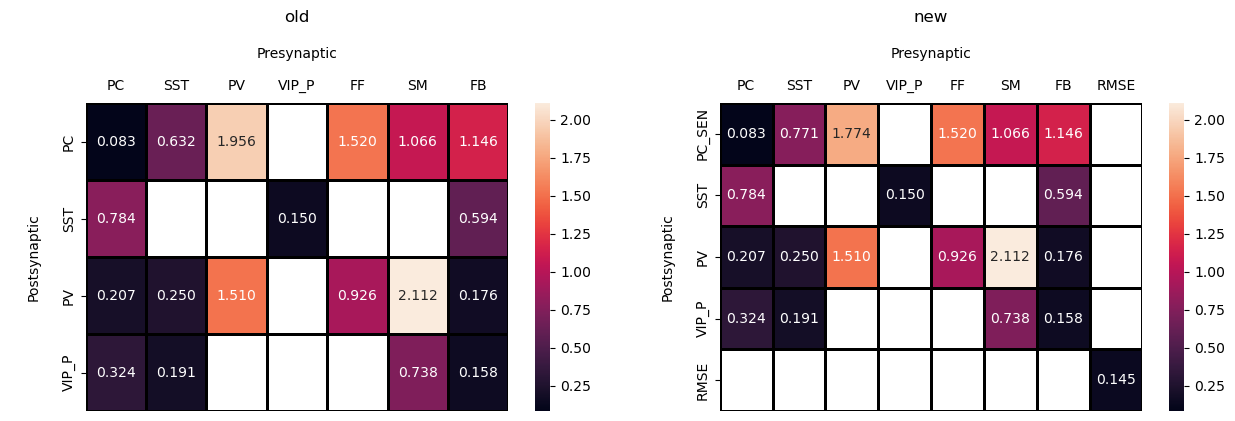

In [94]:
heat_new = pd.DataFrame()
heat_new[''] = ['PC_SEN', 'SST', 'PV', 'VIP_P', 'RMSE']

heat_new['PC'] = [result_nelder.params["w_d_0"].value / scale,
                  0.78370724,
                  0.20723919,
                  0.32398988,
                  None]

heat_new['SST'] = [result_nelder.params["w_d_5"].value / scale,
                  None,
                  0.25013329,
                  0.19112577,
                  None]

heat_new['PV'] = [result_nelder.params["w_d_4"].value / scale,
                   None,
                   1.51029559,
                   None,
                   None]

heat_new['VIP_P'] = [None,
                   0.14997032,
                   None,
                   None,
                   None]


heat_new['FF'] = [result_nelder.params["w_d_1"].value / scale,
                   None,
                   0.92636845,
                   None,
                   None]

heat_new['SM'] = [result_nelder.params["w_d_2"].value / scale,
                   None,
                   2.11169434,
                   0.73762300,
                   None]

heat_new['FB'] = [result_nelder.params["w_d_3"].value / scale,
                   0.59415933,
                   0.17580747,
                   0.15806817,
                   None]

heat_new['RMSE'] = [None,
                   None,
                   None,
                   None,
                   a_nelder]

heat_new.set_index('', inplace = True)

heat_new = heat_new.map(lambda x: np.nan if x is None else x)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.heatmap(heat_old, ax=ax[0], annot = True, linewidth = 1, linecolor = 'black', fmt=".3f")
sns.heatmap(heat_new, ax=ax[1], annot = True, linewidth = 1, linecolor = 'black', fmt=".3f")
ax[0].tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax[0].set(xlabel="\nPresynaptic\n", ylabel="\nPostsynaptic\n")
ax[0].title.set_text("old")
ax[0].xaxis.set_label_position("top")
ax[1].tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax[1].set(xlabel="\nPresynaptic\n", ylabel="\nPostsynaptic\n")
ax[1].title.set_text("new")
ax[1].xaxis.set_label_position("top")
display.display(fig)

In [95]:
heat_new.to_csv("heatmap_C_s1_hab_Loco_SEN_07_04_2025.csv")